In [1]:
import numpy as np
import pandas as pd
import arviz as az
from collections import defaultdict

def create_manual_trace(att_str, def_str, baseline, home_adv, n_samples=1000, pin_first_team=True):
    """
    Create a manual trace dictionary from parameter arrays.
    
    Parameters:
    -----------
    att_str : array-like, shape (n_teams,)
        Attack strength for each team
    def_str : array-like, shape (n_teams,)
        Defense strength for each team
    baseline : float
        Baseline goal rate
    home_adv : float
        Home advantage parameter
    n_samples : int
        Number of posterior samples to generate (default: 1000)
    pin_first_team : bool
        If True, keeps index 0 team values fixed and adjusts other 19 teams to sum to zero
        
    Returns:
    --------
    dict : Manual trace dictionary that can be used with predict_match
    """
    att_str = np.array(att_str, dtype=float).copy()
    def_str = np.array(def_str, dtype=float).copy()
    
    # Pin first team and adjust others to maintain zero-sum
    if pin_first_team:
        # Calculate what the sum of teams 1-19 needs to be to make total = 0
        # If Arsenal = 0.5 and we want total = 0, then others must sum to -0.5
        required_att_sum = -att_str[0]
        required_def_sum = -def_str[0]
        
        # Current sum of teams 1-19
        current_att_sum = att_str[1:].sum()
        current_def_sum = def_str[1:].sum()
        
        # Calculate adjustment needed for each of the 19 teams
        # We distribute the difference equally across all 19 teams
        att_adjustment = (required_att_sum - current_att_sum) / 19
        def_adjustment = (required_def_sum - current_def_sum) / 19
        
        # Apply adjustment to teams 1-19
        att_str[1:] += att_adjustment
        def_str[1:] += def_adjustment
    
    # Replicate the values n_samples times to create posterior samples
    return {
        'att_str': np.tile(att_str, (n_samples, 1)),  # Shape: (n_samples, n_teams)
        'def_str': np.tile(def_str, (n_samples, 1)),  # Shape: (n_samples, n_teams)
        'baseline': np.full(n_samples, baseline),      # Shape: (n_samples,)
        'home_adv': np.full(n_samples, home_adv)       # Shape: (n_samples,)
    }

def get_team_strengths(trace, team_mapping, is_manual=False):
    """
    Extract and display team strengths from a trace.
    
    Parameters:
    -----------
    trace : dict or arviz.InferenceData
        The trace to extract from
    team_mapping : dict
        Mapping of team names to indices
    is_manual : bool
        Whether the trace is in manual format
        
    Returns:
    --------
    pd.DataFrame : DataFrame with team strengths
    """
    if is_manual:
        att_str = trace['att_str'][0]
        def_str = trace['def_str'][0]
        baseline = trace['baseline'][0]
        home_adv = trace['home_adv'][0]
    else:
        n_teams = len(team_mapping)
        att_str = np.mean(trace.posterior['att_str'].values.reshape(-1, n_teams), axis=0)
        def_str = np.mean(trace.posterior['def_str'].values.reshape(-1, n_teams), axis=0)
        baseline = np.mean(trace.posterior['baseline'].values.flatten())
        home_adv = np.mean(trace.posterior['home_adv'].values.flatten())
    
    # Create DataFrame
    team_names = [name for name, idx in sorted(team_mapping.items(), key=lambda x: x[1])]
    df = pd.DataFrame({
        'team': team_names,
        'attack': att_str,
        'defense': def_str
    })
    
    df = df.sort_values('attack', ascending=False)
    
    print(f"\nBaseline: {baseline:.4f}")
    print(f"Home Advantage: {home_adv:.4f}")
    print(f"\nAttack sum: {att_str.sum():.6f}")
    print(f"Defense sum: {def_str.sum():.6f}")
    
    return df

def predict_match(home_team, away_team, trace, team_mapping, is_manual=False):
    """
    Predict goals for a match between two teams using loaded trace or manual trace
    
    Parameters:
    -----------
    home_team : str
        Name of home team
    away_team : str
        Name of away team
    trace : arviz.InferenceData or dict
        Either a loaded ArviZ trace or a manual trace dictionary
    team_mapping : dict
        Mapping of team names to indices
    is_manual : bool
        If True, treat trace as a manual dictionary. If False, treat as ArviZ object
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples based on trace type
    if is_manual:
        # Manual trace - already in correct format
        att_str = trace['att_str']
        def_str = trace['def_str']
        baseline = trace['baseline']
        home_adv = trace['home_adv']
    else:
        # ArviZ trace - extract from posterior
        att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
        def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
        baseline = trace.posterior['baseline'].values.flatten()
        home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    )
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    )
    
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

def simulate_full_season(trace, team_mapping, is_manual=False):
    """
    Simulate a full season where every team plays every other team home and away
    
    Parameters:
    -----------
    trace : arviz.InferenceData or dict
        Either a loaded ArviZ trace or a manual trace dictionary
    team_mapping : dict
        Mapping of team names to indices
    is_manual : bool
        If True, treat trace as a manual dictionary
    """
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,
        'xg_against': 0.0,
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Generate all possible matches
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                # Predict the match
                result = predict_match(home_team, away_team, trace, team_mapping, is_manual)
                
                # Use Poisson goals
                home_goals = np.random.poisson(result['home_goals_expected'])
                away_goals = np.random.poisson(result['away_goals_expected'])
                
                # Store match result
                match_result = {
                    'home_team': home_team,
                    'away_team': away_team,
                    'home_goals': home_goals,
                    'away_goals': away_goals,
                    'home_expected': result['home_goals_expected'],
                    'away_expected': result['away_goals_expected']
                }
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += result['home_goals_expected']
                league_table[home_team]['xg_against'] += result['away_goals_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += result['away_goals_expected']
                league_table[away_team]['xg_against'] += result['home_goals_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

def run_multiple_seasons(n_simulations, trace, team_mapping, is_manual=False):
    """
    Run multiple season simulations and return averaged results
    
    Parameters:
    -----------
    n_simulations : int
        Number of seasons to simulate
    trace : arviz.InferenceData or dict
        Either a loaded ArviZ trace or a manual trace dictionary
    team_mapping : dict
        Mapping of team names to indices
    is_manual : bool
        If True, treat trace as a manual dictionary
    """
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation
        league_table, _ = simulate_full_season(trace, team_mapping, is_manual)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': (stats['total_xg_for'] / n_simulations)/ 38,
            'avg_xg_against':( stats['total_xg_against'] / n_simulations) /38,
            'avg_position': stats['position_sum'] / n_simulations
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

In [2]:
team_mapping = {
    'Arsenal': 0,
    'Aston Villa': 1,
    'Bournemouth': 2,
    'Brentford': 3,
    'Brighton': 4,
    'Chelsea': 5,
    'Crystal Palace': 6,
    'Everton': 7,
    'Fulham': 8,
    'Luton': 9,      # Promoted - using Luton's values as proxy
    'Leicester': 10,  # Promoted - using Burnley's values as proxy
    'Liverpool': 11,
    'Man City': 12,
    'Man United': 13,
    'Newcastle': 14,
    'Nottm Forest': 15,
    'Sheffield United': 16,  # Promoted - using Sheff Utd's values as proxy
    'Tottenham': 17,
    'West Ham': 18,
    'Wolves': 19
}

In [38]:
def calculate_required_strengths(target_xgf, target_xga, baseline, home_adv,
                                 other_teams_att, other_teams_def):
    """
    Calculate the attack and defense strengths needed to achieve target xG.
    
    Parameters:
    -----------
    target_xgf : float
        Target expected goals FOR per game
    target_xga : float
        Target expected goals AGAINST per game
    baseline : float
        Model baseline
    home_adv : float
        Home advantage
    other_teams_att : array-like
        Attack strengths of the other 19 teams
    other_teams_def : array-like
        Defense strengths of the other 19 teams
    
    Returns:
    --------
    tuple : (required_att_strength, required_def_strength)
    """
    other_teams_att = np.array(other_teams_att)
    other_teams_def = np.array(other_teams_def)
    
    # Calculate average opponent strengths (what this team actually faces)
    avg_opp_att = np.mean(other_teams_att)
    avg_opp_def = np.mean(other_teams_def)
    
    # For xG FOR:
    # Home: exp(baseline + att + opp_def + home_adv) for each opponent
    # Away: exp(baseline + att + opp_def) for each opponent
    # We need: (sum of home_xg + sum of away_xg) / 38 = target_xgf
    
    # Average over opponents:
    # target_xgf = (exp(baseline + att + avg_opp_def + home_adv) + exp(baseline + att + avg_opp_def)) / 2
    # 2*target_xgf = exp(baseline + att + avg_opp_def) * (exp(home_adv) + 1)
    # exp(baseline + att + avg_opp_def) = 2*target_xgf / (exp(home_adv) + 1)
    # att = ln(2*target_xgf / (exp(home_adv) + 1)) - baseline - avg_opp_def
    
    required_att = np.log(2 * target_xgf / (np.exp(home_adv) + 1)) - baseline - avg_opp_def
    
    # For xG AGAINST:
    # Home: exp(baseline + opp_att + def) for each opponent
    # Away: exp(baseline + opp_att + def + home_adv) for each opponent (they get home adv)
    # Average over opponents:
    # target_xga = (exp(baseline + avg_opp_att + def) + exp(baseline + avg_opp_att + def + home_adv)) / 2
    # 2*target_xga = exp(baseline + avg_opp_att + def) * (1 + exp(home_adv))
    # exp(baseline + avg_opp_att + def) = 2*target_xga / (1 + exp(home_adv))
    # def = ln(2*target_xga / (1 + exp(home_adv))) - baseline - avg_opp_att
    
    required_def = np.log(2 * target_xga / (1 + np.exp(home_adv))) - baseline - avg_opp_att
    
    return required_att, required_def


# Usage:
baseline = 0.283
home_adv = 0.253

# First create initial trace with all teams
att_str_initial = np.array([
    0.35,   # Arsenal (placeholder, will be recalculated)
    0.162,  # Aston Villa
    -0.088, # Bournemouth
    -0.035, # Brentford
    -0.119, # Brighton
    0.26,   # Chelsea
    -0.109, # Crystal Palace
    -0.175, # Everton
    -0.089, # Fulham
    -0.181, # Luton
    -0.392, # Leicester
    0.424,  # Liverpool
    0.365,  # Man City
    -0.079, # Man United
    0.302,  # Newcastle
    -0.188, # Nottm Forest
    -0.414, # Sheffield United
    0.197,  # Tottenham
    -0.043, # West Ham
    -0.151  # Wolves
])

def_str_initial = np.array([
    -0.712, # Arsenal (placeholder, will be recalculated)
    0.086,  # Aston Villa
    0.015,  # Bournemouth
    -0.04,  # Brentford
    -0.018, # Brighton
    0.043,  # Chelsea
    -0.099, # Crystal Palace
    -0.085, # Everton
    0.021,  # Fulham
    0.314,  # Luton
    0.207,  # Leicester
    -0.217, # Liverpool
    -0.436, # Man City
    0.104,  # Man United
    0.069,  # Newcastle
    -0.04,  # Nottm Forest
    0.392,  # Sheffield United
    0.103,  # Tottenham
    0.225,  # West Ham
    0.068   # Wolves
])


# Calculate required strengths for Arsenal to achieve 1.5 xGF, 0.5 xGA
# Note: we need to account for what the other teams will be AFTER adjustment
# This is iterative - let's do a simple approach first

# Step 1: Calculate what Arsenal needs assuming others stay as is
other_att = att_str_initial[1:]
other_def = def_str_initial[1:]

att_strength, def_strength = calculate_required_strengths(
    target_xgf=1.5,
    target_xga=0.5,
    baseline=baseline,
    home_adv=home_adv,
    other_teams_att=other_att,
    other_teams_def=other_def
)

print(f"Required attack strength: {att_strength:.4f}")
print(f"Required defense strength: {def_strength:.4f}")

# Step 2: Now we need to account for the adjustment that will happen
# When we pin Arsenal, the other 19 teams get adjusted
# Let's iterate to find the true values

att_str = att_str_initial.copy()
def_str = def_str_initial.copy()

for iteration in range(10):  # Iterate until convergence
    # Set Arsenal's strengths
    att_str[0] = att_strength
    def_str[0] = def_strength
    
    # Calculate what adjustment will be made to other teams
    required_att_sum = -att_str[0]
    required_def_sum = -def_str[0]
    
    current_att_sum = att_str[1:].sum()
    current_def_sum = def_str[1:].sum()
    
    att_adjustment = (required_att_sum - current_att_sum) / 19
    def_adjustment = (required_def_sum - current_def_sum) / 19
    
    # Apply adjustment
    att_str[1:] += att_adjustment
    def_str[1:] += def_adjustment
    
    # Recalculate required strengths based on adjusted opponents
    att_strength_new, def_strength_new = calculate_required_strengths(
        target_xgf=1.5,
        target_xga=0.5,
        baseline=baseline,
        home_adv=home_adv,
        other_teams_att=att_str[1:],
        other_teams_def=def_str[1:]
    )
    
    # Check convergence
    if abs(att_strength_new - att_strength) < 0.0001 and abs(def_strength_new - def_strength) < 0.0001:
        print(f"Converged after {iteration + 1} iterations")
        break
    
    att_strength = att_strength_new
    def_strength = def_strength_new

print(f"\nFinal attack strength: {att_strength:.4f}")
print(f"Final defense strength: {def_strength:.4f}")

# Now use these values
att_str[0] = att_strength
def_str[0] = def_strength


# Create manual trace with pin_first_team=True
manual_trace = create_manual_trace(
    att_str=att_str,
    def_str=def_str,
    baseline=baseline,
    home_adv=home_adv,
    n_samples=1000,
    pin_first_team=True
)

print("\n" + "="*50)
print("Verification:")
df = get_team_strengths(manual_trace, team_mapping, is_manual=True)
print(df.head())

results = run_multiple_seasons(10000, manual_trace, team_mapping, is_manual=True)

results

Required attack strength: -0.0495
Required defense strength: -1.0920
Converged after 3 iterations

Final attack strength: -0.0706
Final defense strength: -1.1143

Verification:

Baseline: 0.2830
Home Advantage: 0.2530

Attack sum: 0.000000
Defense sum: 0.000000
         team    attack   defense
11  Liverpool  0.446295 -0.195827
12   Man City  0.387295 -0.414827
14  Newcastle  0.324295  0.090173
5     Chelsea  0.282295  0.064173
17  Tottenham  0.219295  0.124173
Running 10000 season simulations...
Completed 1000 simulations...
Completed 2000 simulations...
Completed 3000 simulations...
Completed 4000 simulations...
Completed 5000 simulations...
Completed 6000 simulations...
Completed 7000 simulations...
Completed 8000 simulations...
Completed 9000 simulations...
Completed 10000 simulations...


(                team  avg_points  avg_wins  avg_draws  avg_losses  \
 1           Man City     81.7846   24.9965     6.7951      6.2084   
 2            Arsenal     79.6880   23.3548     9.6236      5.0216   
 3          Liverpool     78.2545   23.8675     6.6520      7.4805   
 4          Newcastle     63.4972   18.7429     7.2685     11.9886   
 5            Chelsea     62.5146   18.3305     7.5231     12.1464   
 6          Tottenham     57.5837   16.6477     7.6406     13.7117   
 7        Aston Villa     56.7034   16.3322     7.7068     13.9610   
 8          Brentford     53.3406   14.9292     8.5530     14.5178   
 9     Crystal Palace     52.5828   14.5327     8.9847     14.4826   
 10           Everton     49.7584   13.5515     9.1039     15.3446   
 11          Brighton     49.4347   13.5672     8.7331     15.6997   
 12       Bournemouth     49.3059   13.5822     8.5593     15.8585   
 13            Fulham     49.2103   13.5618     8.5249     15.9133   
 14      Nottm Fores

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_required_strengths(target_xgf, target_xga, baseline, home_adv,
                                 other_teams_att, other_teams_def):
    """Calculate attack and defense strengths needed to achieve target xG."""
    other_teams_att = np.array(other_teams_att)
    other_teams_def = np.array(other_teams_def)
    
    avg_opp_att = np.mean(other_teams_att)
    avg_opp_def = np.mean(other_teams_def)
    
    required_att = np.log(2 * target_xgf / (np.exp(home_adv) + 1)) - baseline - avg_opp_def
    required_def = np.log(2 * target_xga / (1 + np.exp(home_adv))) - baseline - avg_opp_att
    
    return required_att, required_def

def run_grid_search(xgf_range, xga_range, baseline, home_adv, 
                   att_str_initial, def_str_initial, n_seasons=1000):
    """
    Run grid search over xGF and xGA values.
    
    Returns:
    --------
    results : dict with keys 'xgf_vals', 'xga_vals', 'avg_points', 'std_points', 
                             'all_points', 'marginal_xgf', 'marginal_xga'
    """
    xgf_vals = np.linspace(xgf_range[0], xgf_range[1], 11)
    xga_vals = np.linspace(xga_range[0], xga_range[1], 11)
    
    avg_points = np.zeros((len(xga_vals), len(xgf_vals)))
    std_points = np.zeros((len(xga_vals), len(xgf_vals)))
    all_points = np.zeros((len(xga_vals), len(xgf_vals), n_seasons))  # Store all simulations
    
    total_iterations = len(xga_vals) * len(xgf_vals)
    current_iteration = 0
    
    for i, xga in enumerate(xga_vals):
        for j, xgf in enumerate(xgf_vals):
            current_iteration += 1
            print(f"Progress: {current_iteration}/{total_iterations} - xGF={xgf:.1f}, xGA={xga:.1f}")
            
            # Calculate required strengths with iteration
            att_str = att_str_initial.copy()
            def_str = def_str_initial.copy()
            
            other_att = att_str[1:]
            other_def = def_str[1:]
            
            att_strength, def_strength = calculate_required_strengths(
                target_xgf=xgf,
                target_xga=xga,
                baseline=baseline,
                home_adv=home_adv,
                other_teams_att=other_att,
                other_teams_def=other_def
            )
            
            # Iterate to account for adjustments
            for _ in range(10):
                att_str[0] = att_strength
                def_str[0] = def_strength
                
                required_att_sum = -att_str[0]
                required_def_sum = -def_str[0]
                
                current_att_sum = att_str[1:].sum()
                current_def_sum = def_str[1:].sum()
                
                att_adjustment = (required_att_sum - current_att_sum) / 19
                def_adjustment = (required_def_sum - current_def_sum) / 19
                
                att_str[1:] += att_adjustment
                def_str[1:] += def_adjustment
                
                att_strength_new, def_strength_new = calculate_required_strengths(
                    target_xgf=xgf,
                    target_xga=xga,
                    baseline=baseline,
                    home_adv=home_adv,
                    other_teams_att=att_str[1:],
                    other_teams_def=def_str[1:]
                )
                
                if abs(att_strength_new - att_strength) < 0.0001 and abs(def_strength_new - def_strength) < 0.0001:
                    break
                
                att_strength = att_strength_new
                def_strength = def_strength_new
            
            att_str[0] = att_strength
            def_str[0] = def_strength
            
            # Create manual trace and run simulation
            manual_trace = create_manual_trace(
                att_str=att_str,
                def_str=def_str,
                baseline=baseline,
                home_adv=home_adv,
                n_samples=1000,
                pin_first_team=True
            )
            
            # Run multiple seasons and store ALL results
            points_list = []
            for season_idx in range(n_seasons):
                if season_idx % 100 == 0:
                    print(f"  Simulating season {season_idx}/{n_seasons}")
                
                league_table, _ = simulate_full_season(manual_trace, team_mapping, is_manual=True)
                arsenal_points = league_table['Arsenal']['points']
                points_list.append(arsenal_points)
            
            # Store results
            all_points[i, j, :] = points_list
            avg_points[i, j] = np.mean(points_list)
            std_points[i, j] = np.std(points_list)
            
            print(f"  Result: {avg_points[i, j]:.1f} ± {std_points[i, j]:.1f} points\n")
    
    # Calculate marginal effects (change in points per unit change)
    xgf_step = xgf_vals[1] - xgf_vals[0]
    xga_step = xga_vals[1] - xga_vals[0]
    
    marginal_xgf = np.gradient(avg_points, axis=1) / xgf_step
    marginal_xga = -np.gradient(avg_points, axis=0) / xga_step  # Negative because lower xGA is better
    
    return {
        'xgf_vals': xgf_vals,
        'xga_vals': xga_vals,
        'avg_points': avg_points,
        'std_points': std_points,
        'all_points': all_points,  # Store all simulation results
        'marginal_xgf': marginal_xgf,
        'marginal_xga': marginal_xga
    }

# Run the grid search
baseline = 0.283
home_adv = 0.253

att_str_initial = np.array([
    0.35, 0.162, -0.088, -0.035, -0.119, 0.26, -0.109, -0.175, -0.089, -0.181,
    -0.392, 0.424, 0.365, -0.079, 0.302, -0.188, -0.414, 0.197, -0.043, -0.151
])

def_str_initial = np.array([
    -0.712, 0.086, 0.015, -0.04, -0.018, 0.043, -0.099, -0.085, 0.021, 0.314,
    0.207, -0.217, -0.436, 0.104, 0.069, -0.04, 0.392, 0.103, 0.225, 0.068
])

print("Running grid search with variance tracking (this may take several hours)...")
print("="*70)

results = run_grid_search(
    xgf_range=(1.5, 2.5),
    xga_range=(0.5, 1.5),
    baseline=baseline,
    home_adv=home_adv,
    att_str_initial=att_str_initial,
    def_str_initial=def_str_initial,
    n_seasons=1000
)

print("\n" + "="*70)
print("GRID SEARCH COMPLETE!")
print("="*70)

# Save results to avoid having to re-run
import pickle
with open('grid_search_results_with_variance.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Results saved to 'grid_search_results_with_variance.pkl'")

Running grid search with variance tracking (this may take several hours)...
Progress: 1/121 - xGF=1.5, xGA=0.5
  Simulating season 0/1000
  Simulating season 100/1000
  Simulating season 200/1000
  Simulating season 300/1000
  Simulating season 400/1000
  Simulating season 500/1000
  Simulating season 600/1000
  Simulating season 700/1000
  Simulating season 800/1000
  Simulating season 900/1000
  Result: 79.6 ± 7.1 points

Progress: 2/121 - xGF=1.6, xGA=0.5
  Simulating season 0/1000
  Simulating season 100/1000
  Simulating season 200/1000
  Simulating season 300/1000
  Simulating season 400/1000
  Simulating season 500/1000
  Simulating season 600/1000
  Simulating season 700/1000
  Simulating season 800/1000
  Simulating season 900/1000
  Result: 81.7 ± 7.2 points

Progress: 3/121 - xGF=1.7, xGA=0.5
  Simulating season 0/1000
  Simulating season 100/1000
  Simulating season 200/1000
  Simulating season 300/1000
  Simulating season 400/1000
  Simulating season 500/1000
  Simulating 

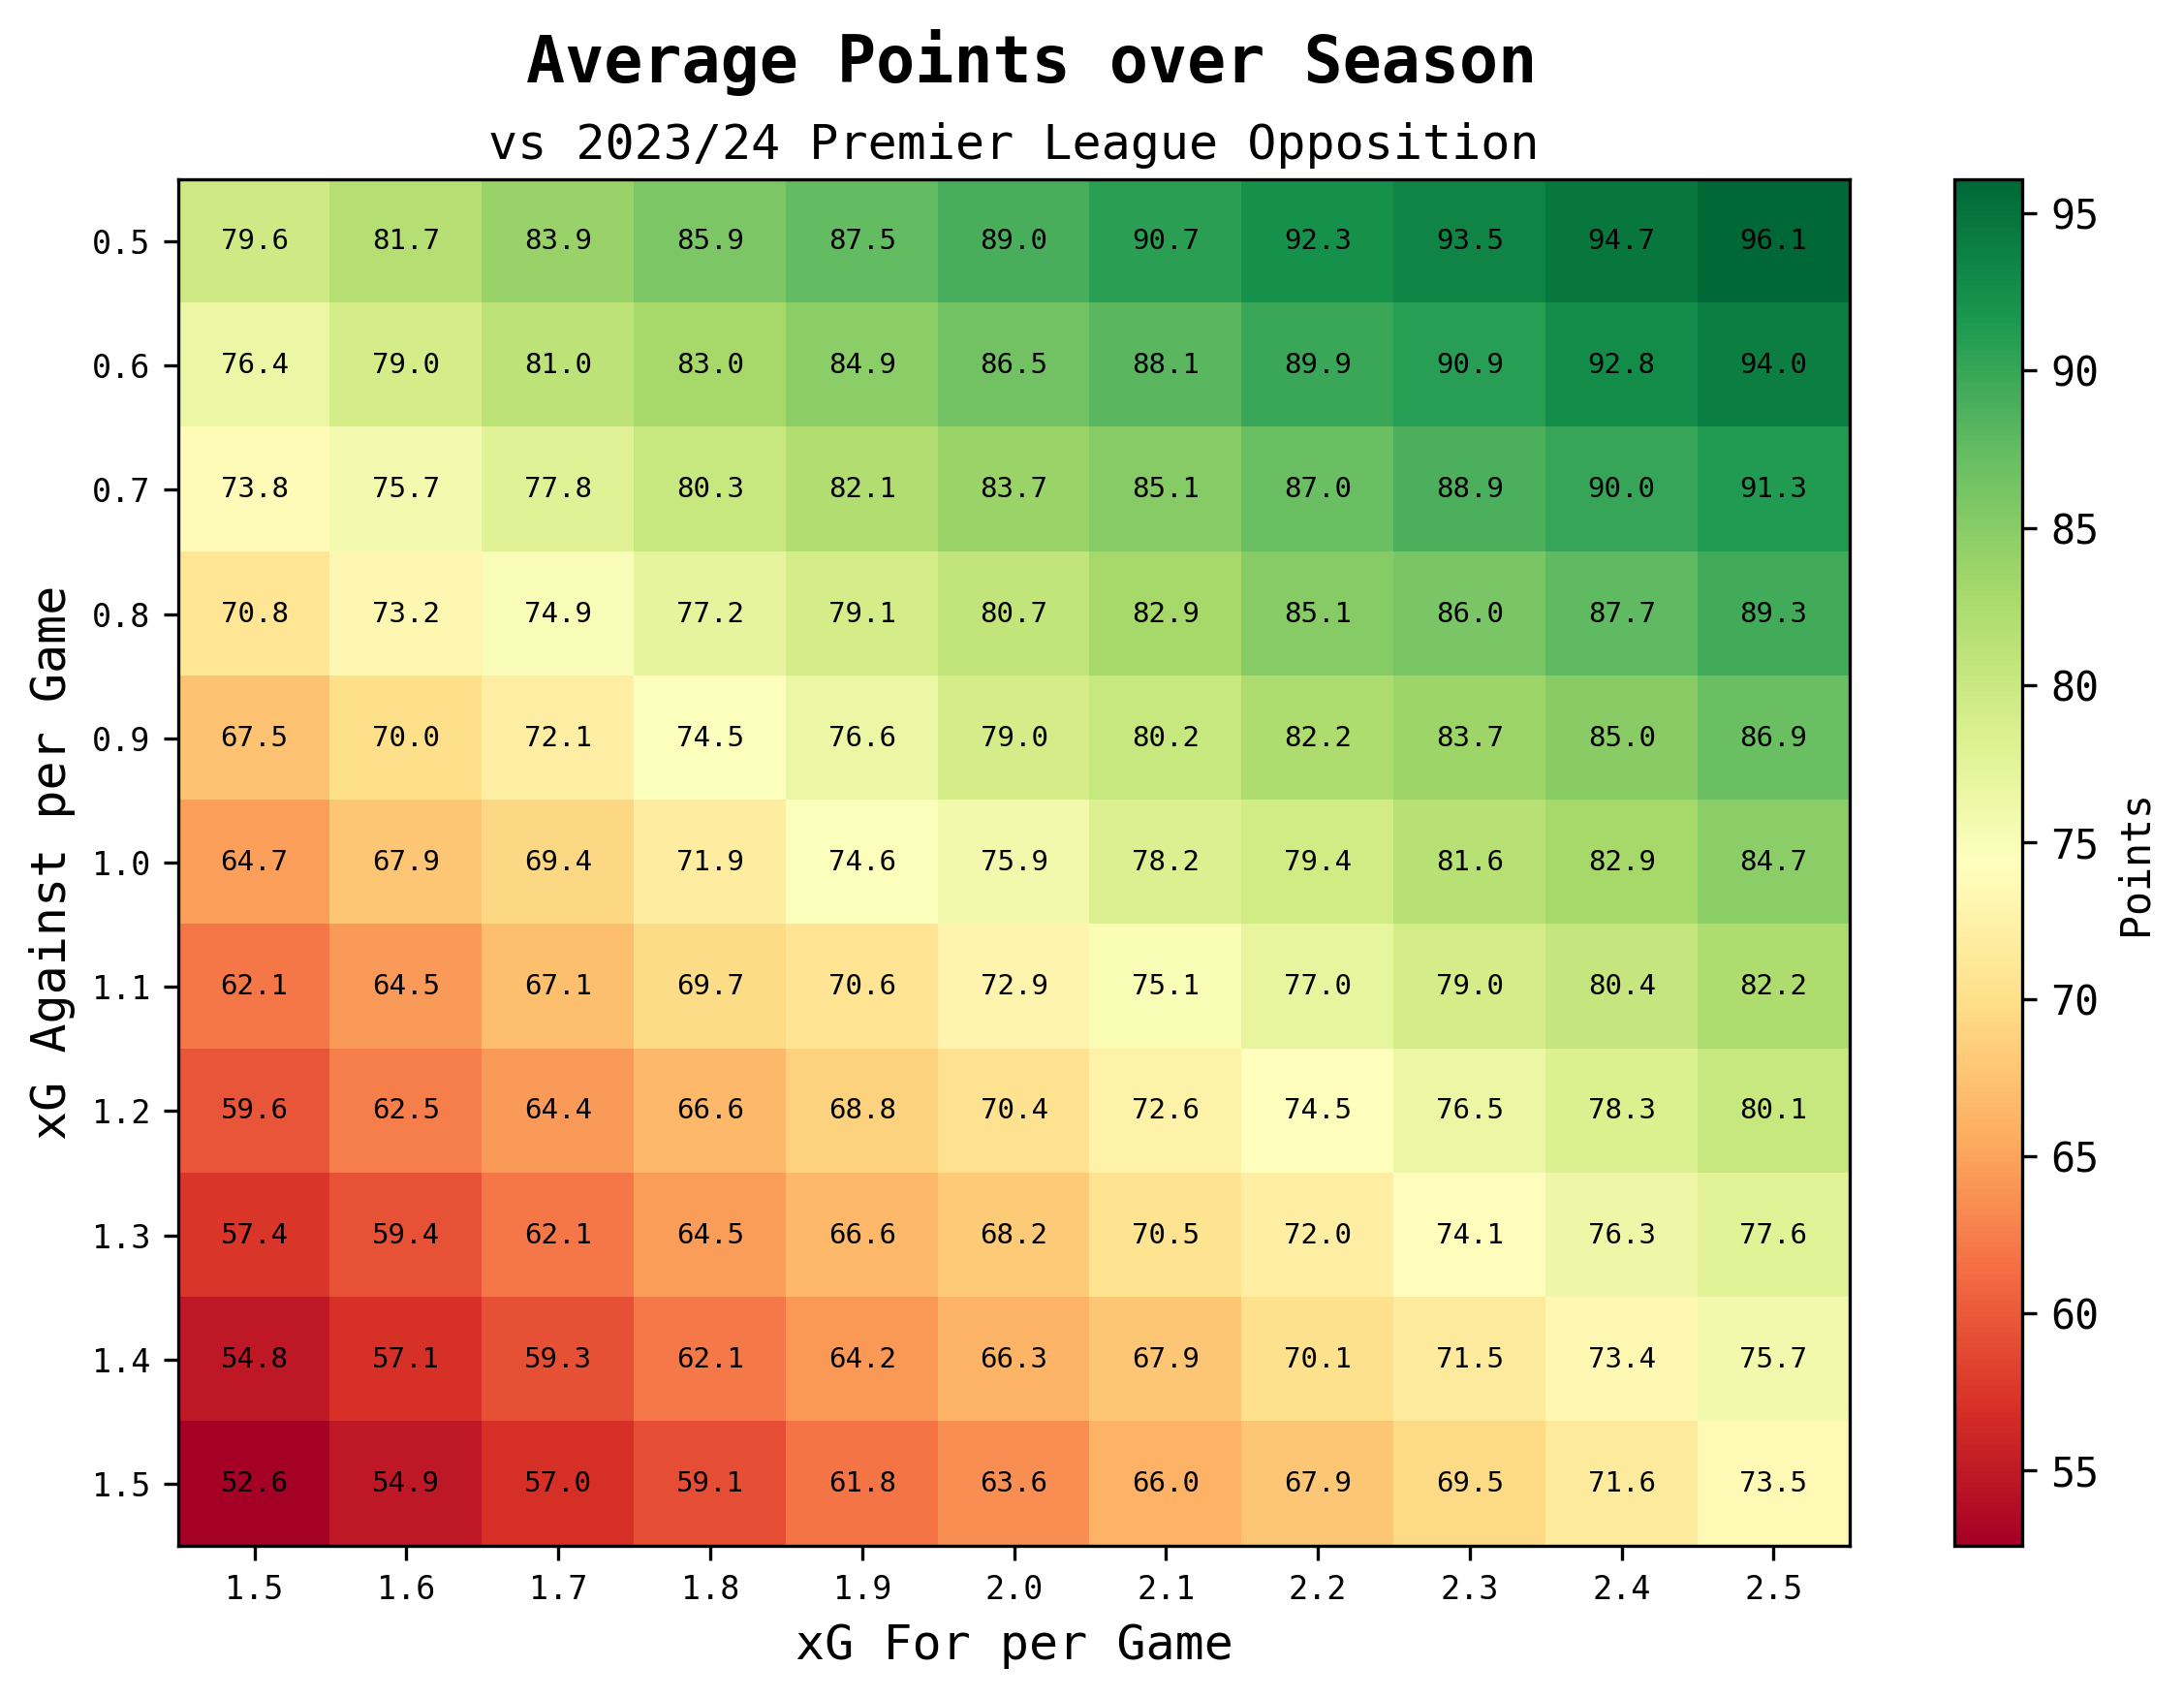

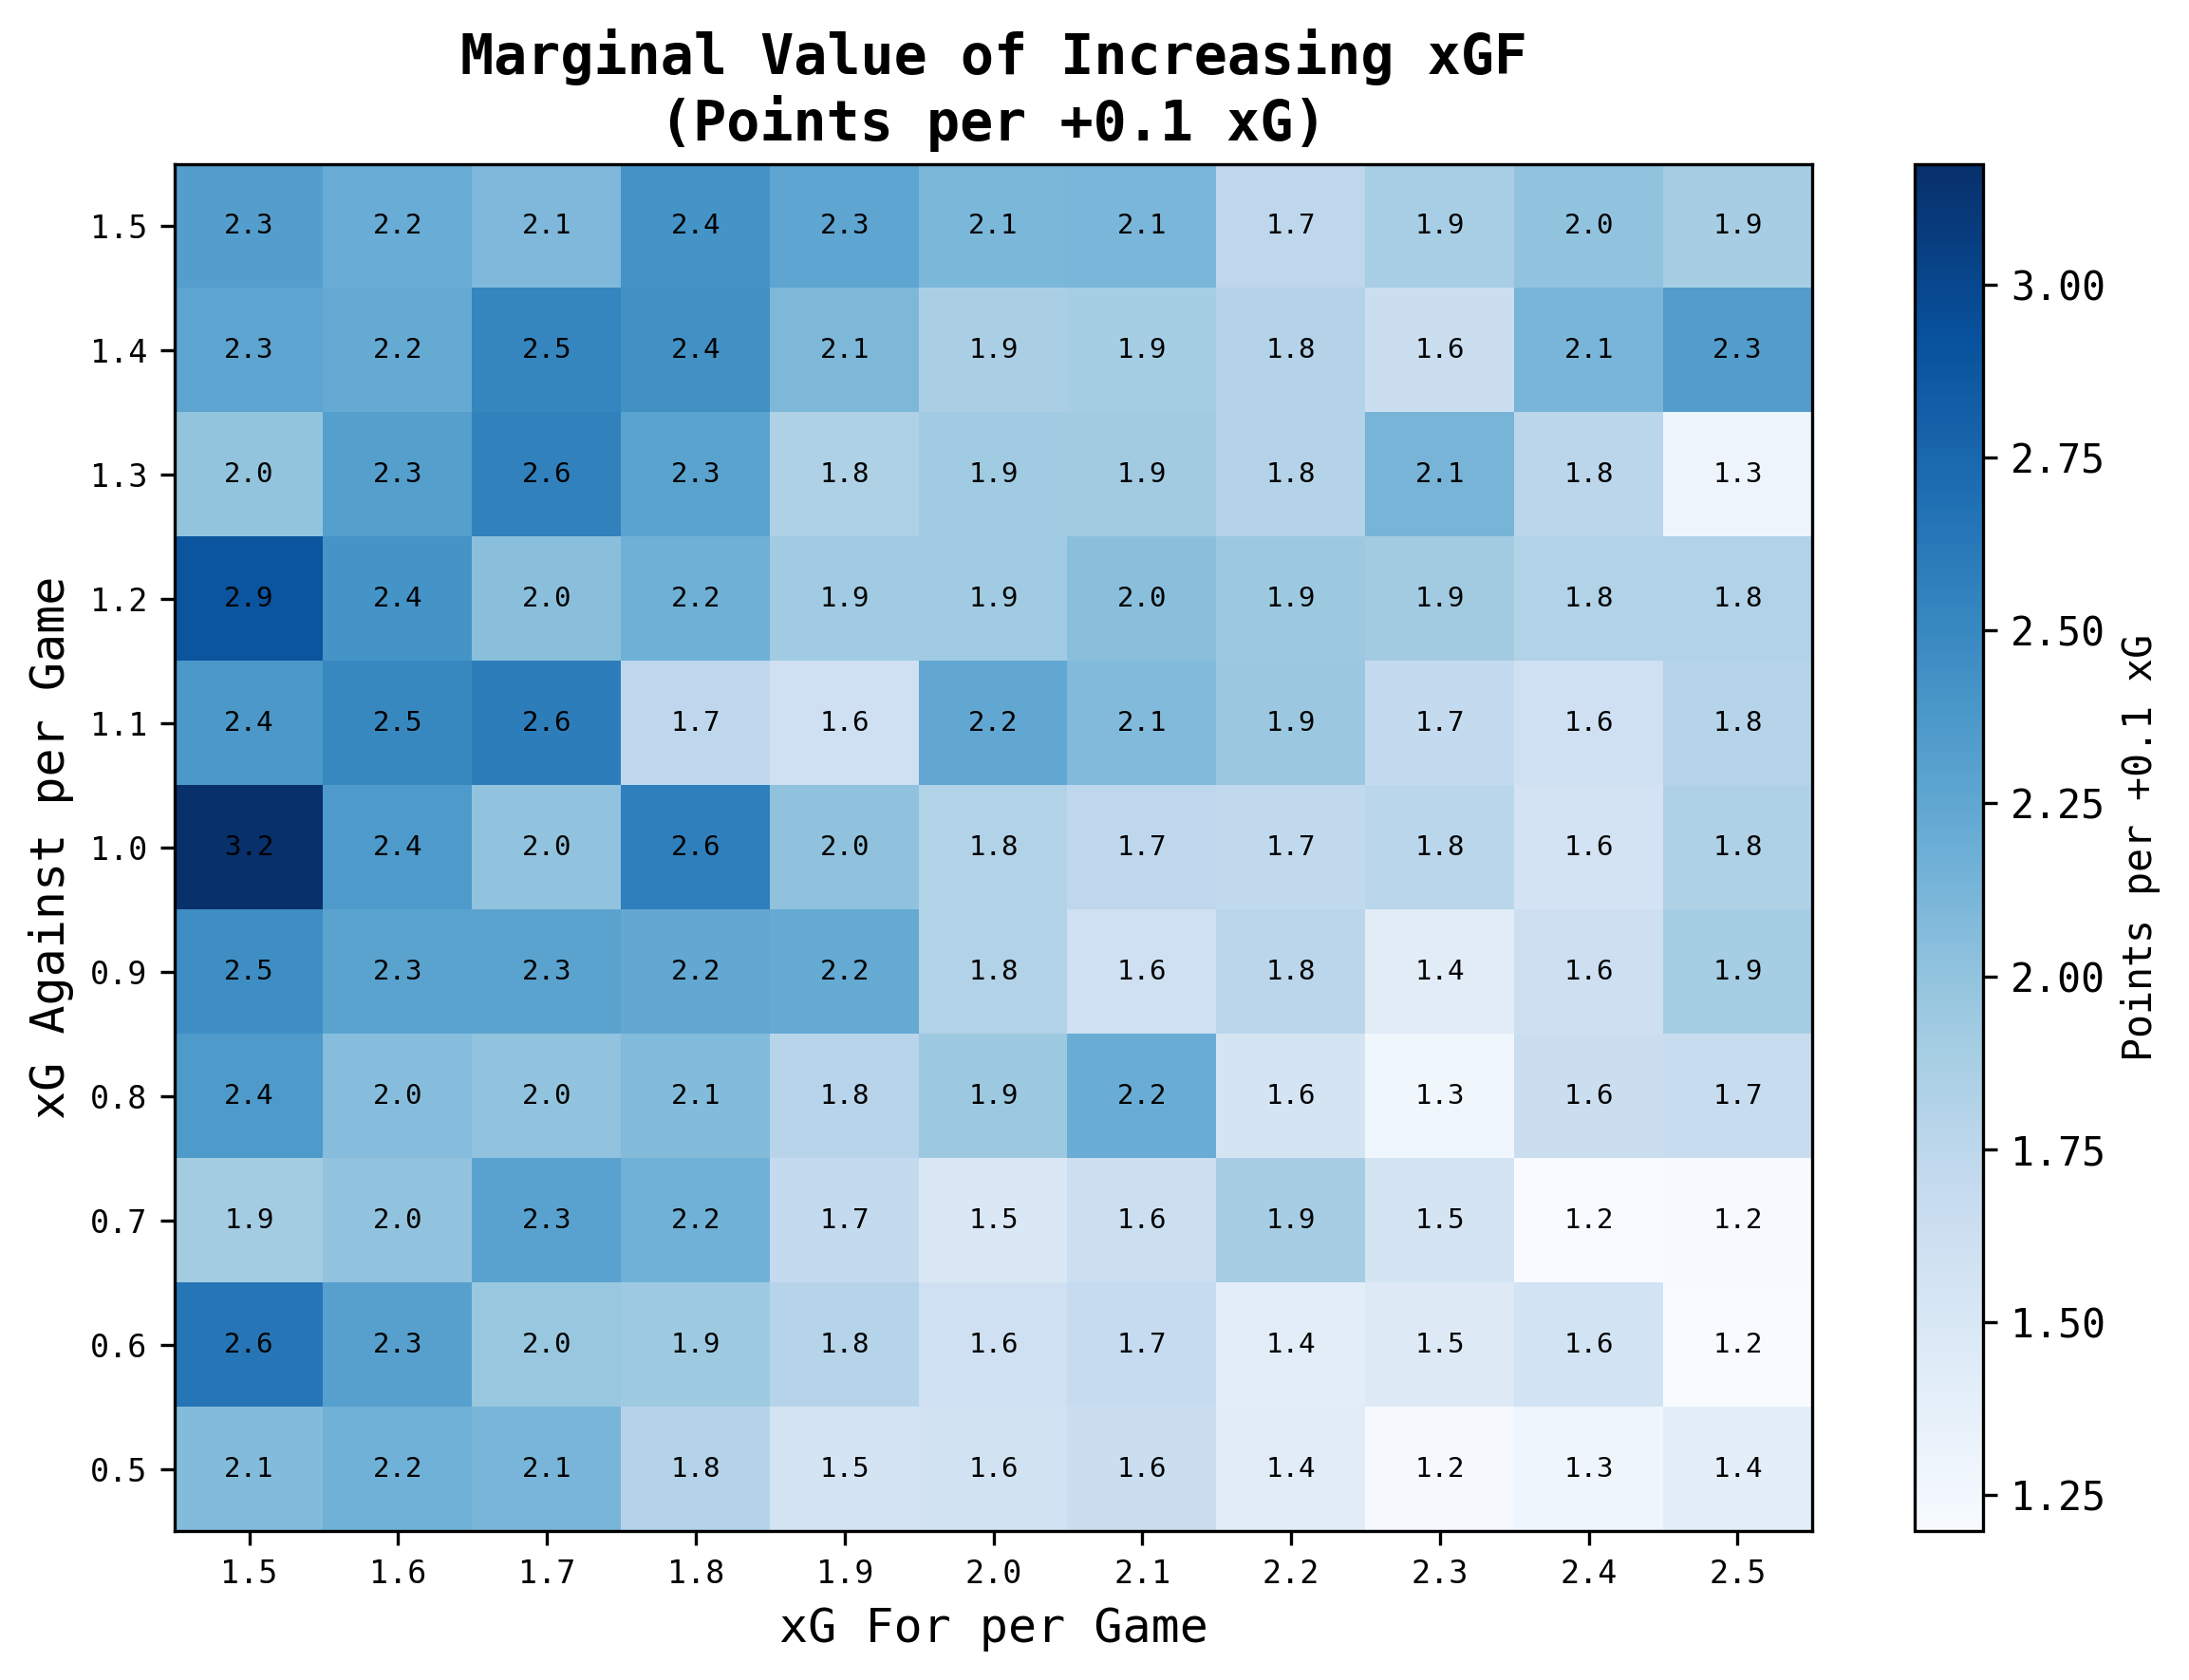

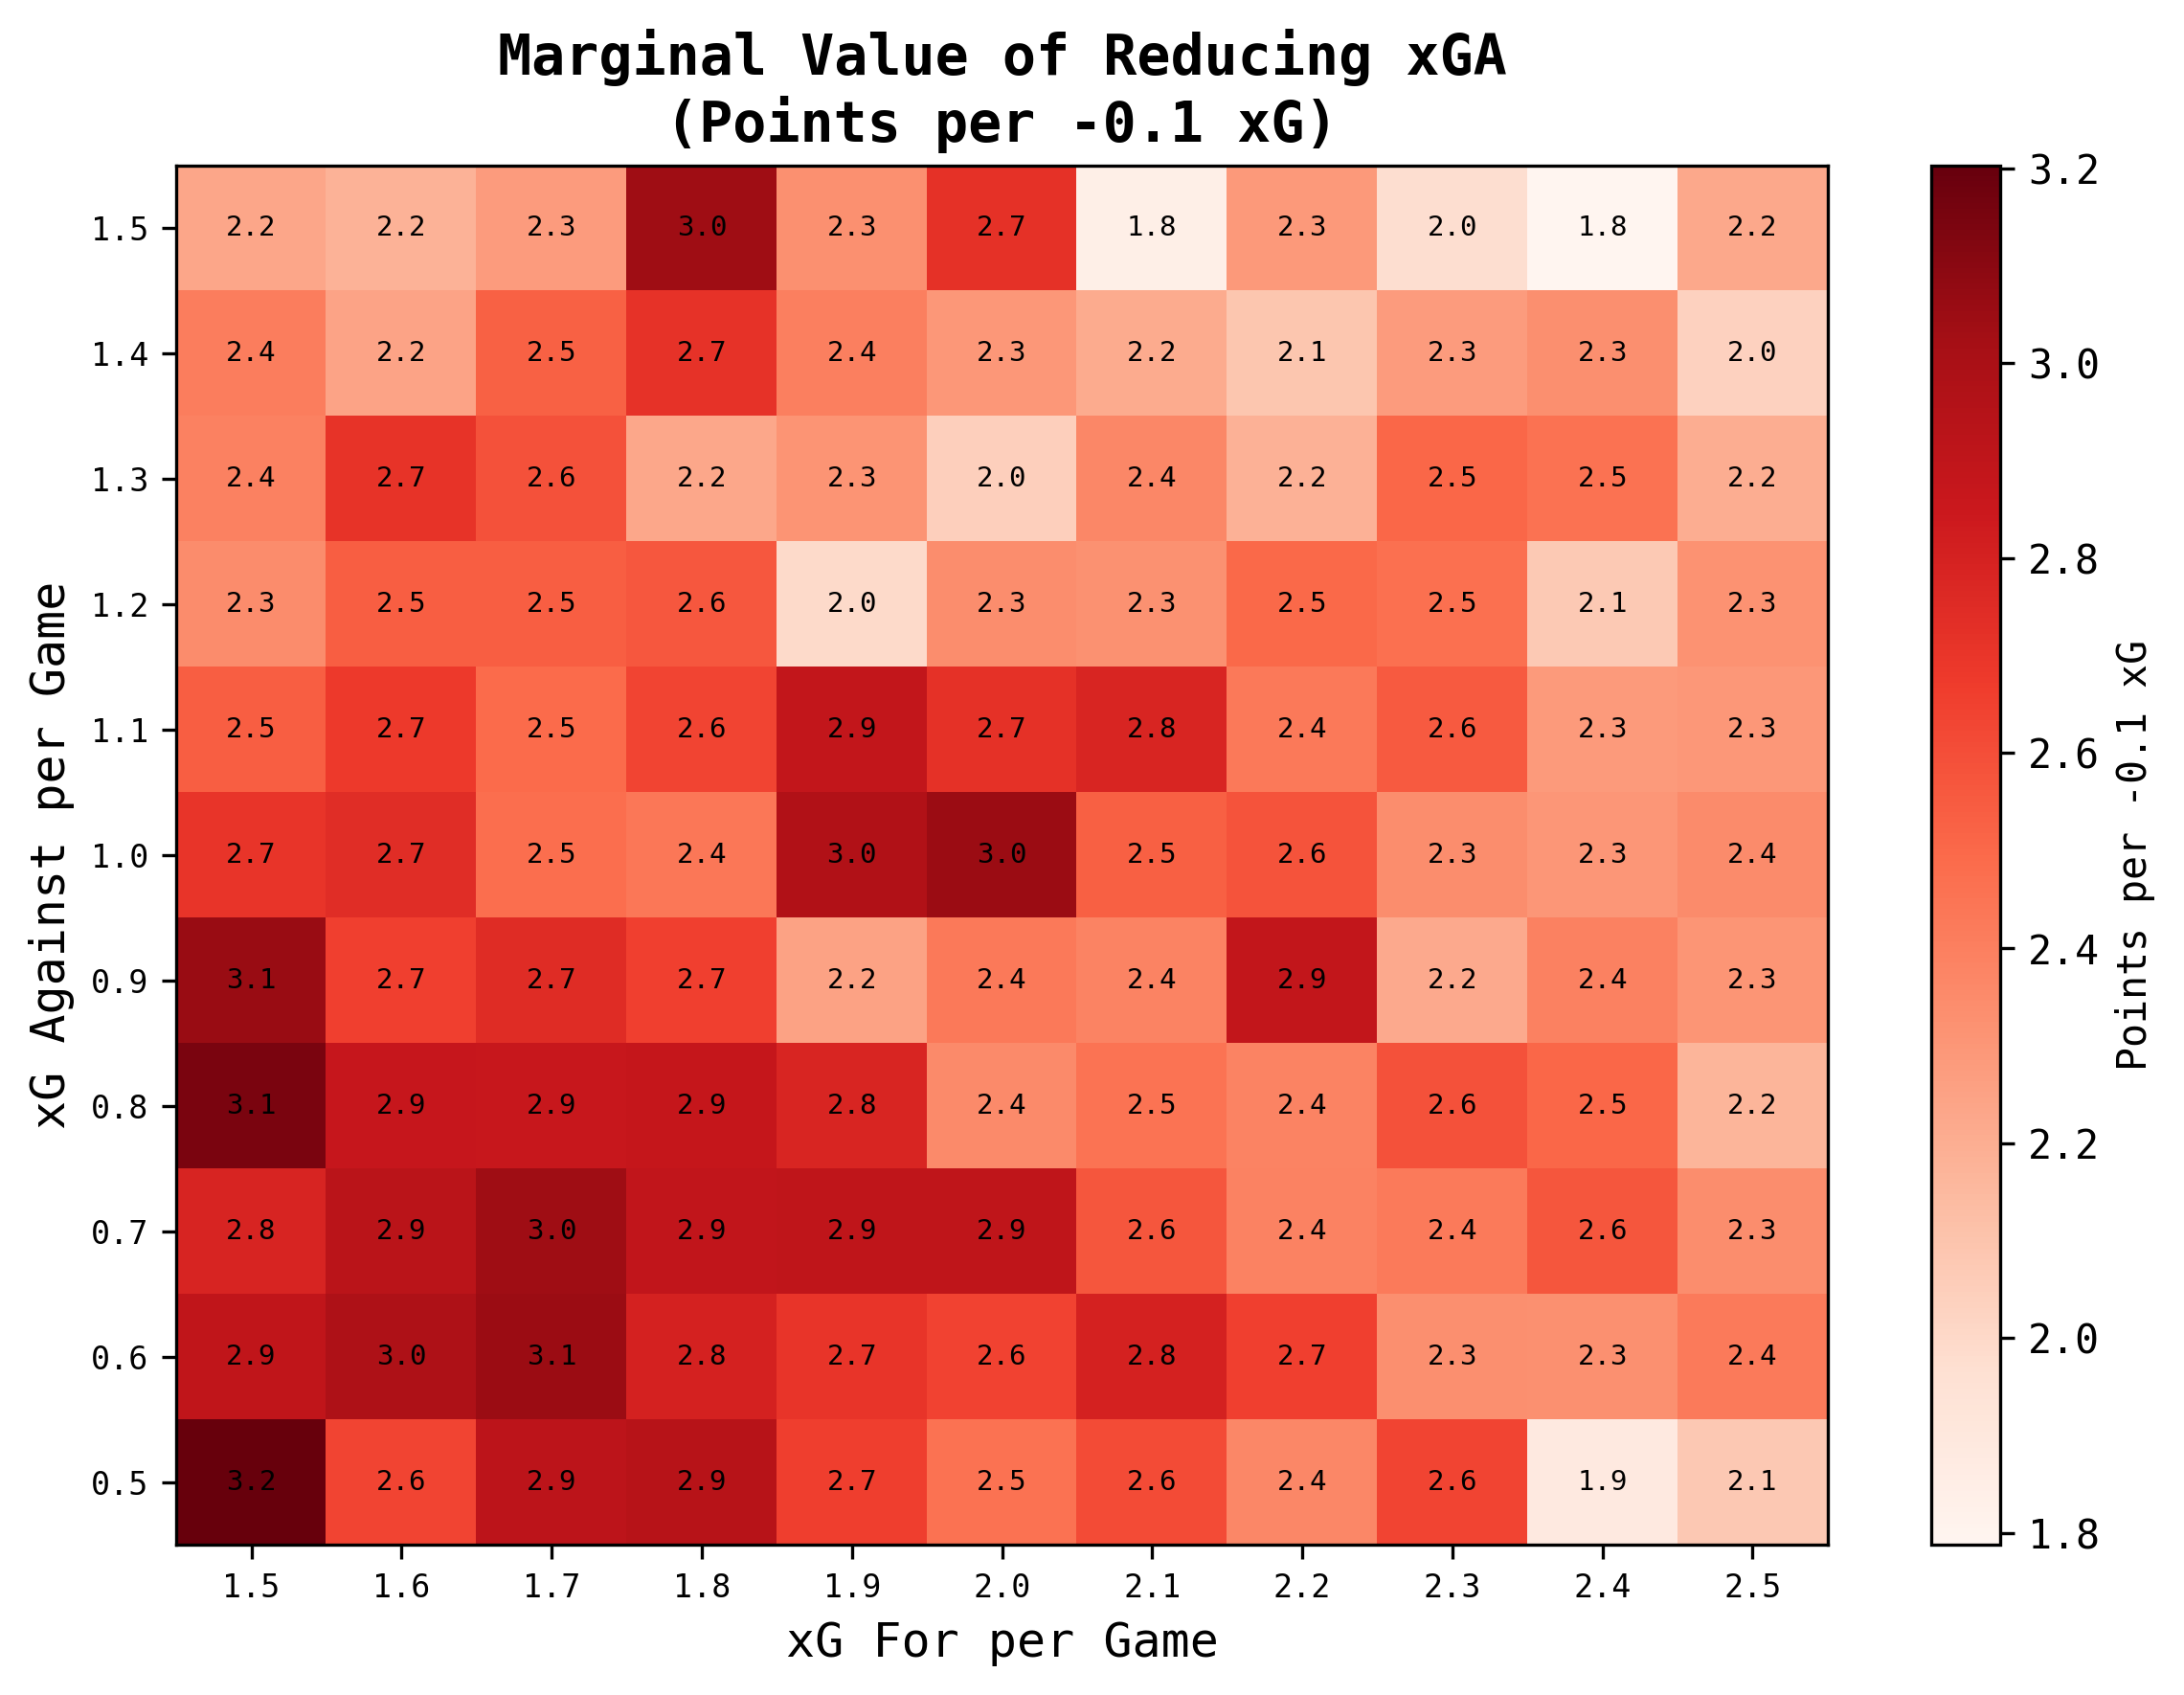


GRID SEARCH SUMMARY
Maximum points: 96.1
  at xGF = 2.50, xGA = 0.50

Average marginal value of increasing xGF: 1.94 pts per 0.1 xG
Average marginal value of reducing xGA: 2.51 pts per 0.1 xG

Ratio (xGA improvement / xGF improvement): 1.30x
  -> Reducing xGA by 0.1 is worth 1.30x more than increasing xGF by 0.1


In [49]:
import sys
sys.path.append('../../style')
from style_config import StyleConfig

# Apply consistent styling
StyleConfig.apply_style()

def plot_heatmaps(results):
    """Create heatmaps for average points and marginal effects."""
    xgf_vals = results['xgf_vals']
    xga_vals = results['xga_vals']
    
    # Calculate step sizes
    xgf_step = xgf_vals[1] - xgf_vals[0]
    xga_step = xga_vals[1] - xga_vals[0]
    
    # Adjust extent to center pixels on data points
    extent = [xgf_vals[0] - xgf_step/2, xgf_vals[-1] + xgf_step/2,
              xga_vals[0] - xga_step/2, xga_vals[-1] + xga_step/2]
    
    # Recalculate marginal effects with correct scaling
    marginal_xgf = np.gradient(results['avg_points'], axis=1) * (0.1 / xgf_step)
    marginal_xga = -np.gradient(results['avg_points'], axis=0) * (0.1 / xga_step)
    
    # Chart 1: Average Points
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    im1 = ax1.imshow(results['avg_points'], aspect='auto', origin='lower',
                     extent=extent, cmap='RdYlGn')
    ax1.set_xlabel('xG For per Game', fontsize=12)
    ax1.set_ylabel('xG Against per Game', fontsize=12)
    fig1.suptitle('Average Points over Season', fontsize=16, fontweight='bold', x=0.45, y=0.965)
    ax1.set_title('vs 2023/24 Premier League Opposition', fontsize=12, pad=5)

    ax1.invert_yaxis()
    
    # Set ticks every 0.1
    ax1.set_xticks(xgf_vals)
    ax1.set_yticks(xga_vals)
    ax1.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax1.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im1, ax=ax1, label='Points')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax1.text(xgf_vals[j], xga_vals[i], f'{results["avg_points"][i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Chart 2: Marginal Effect of xGF
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    im2 = ax2.imshow(marginal_xgf, aspect='auto', origin='lower',
                     extent=extent, cmap='Blues')
    ax2.set_xlabel('xG For per Game', fontsize=12)
    ax2.set_ylabel('xG Against per Game', fontsize=12)
    ax2.set_title('Marginal Value of Increasing xGF\n(Points per +0.1 xG)', fontsize=14, fontweight='bold')
    
    ax2.set_xticks(xgf_vals)
    ax2.set_yticks(xga_vals)
    ax2.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax2.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im2, ax=ax2, label='Points per +0.1 xG')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax2.text(xgf_vals[j], xga_vals[i], f'{marginal_xgf[i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Chart 3: Marginal Effect of xGA
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    im3 = ax3.imshow(marginal_xga, aspect='auto', origin='lower',
                     extent=extent, cmap='Reds')
    ax3.set_xlabel('xG For per Game', fontsize=12)
    ax3.set_ylabel('xG Against per Game', fontsize=12)
    ax3.set_title('Marginal Value of Reducing xGA\n(Points per -0.1 xG)', fontsize=14, fontweight='bold')
    
    ax3.set_xticks(xgf_vals)
    ax3.set_yticks(xga_vals)
    ax3.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax3.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im3, ax=ax3, label='Points per -0.1 xG')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax3.text(xgf_vals[j], xga_vals[i], f'{marginal_xga[i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("GRID SEARCH SUMMARY")
    print("="*60)
    
    max_idx = np.unravel_index(results['avg_points'].argmax(), results['avg_points'].shape)
    print(f"Maximum points: {results['avg_points'][max_idx]:.1f}")
    print(f"  at xGF = {xgf_vals[max_idx[1]]:.2f}, xGA = {xga_vals[max_idx[0]]:.2f}")
    
    print(f"\nAverage marginal value of increasing xGF: {marginal_xgf.mean():.2f} pts per 0.1 xG")
    print(f"Average marginal value of reducing xGA: {marginal_xga.mean():.2f} pts per 0.1 xG")
    
    print(f"\nRatio (xGA improvement / xGF improvement): {marginal_xga.mean() / marginal_xgf.mean():.2f}x")
    print("  -> Reducing xGA by 0.1 is worth {:.2f}x more than increasing xGF by 0.1".format(
        marginal_xga.mean() / marginal_xgf.mean()))

plot_heatmaps(results)

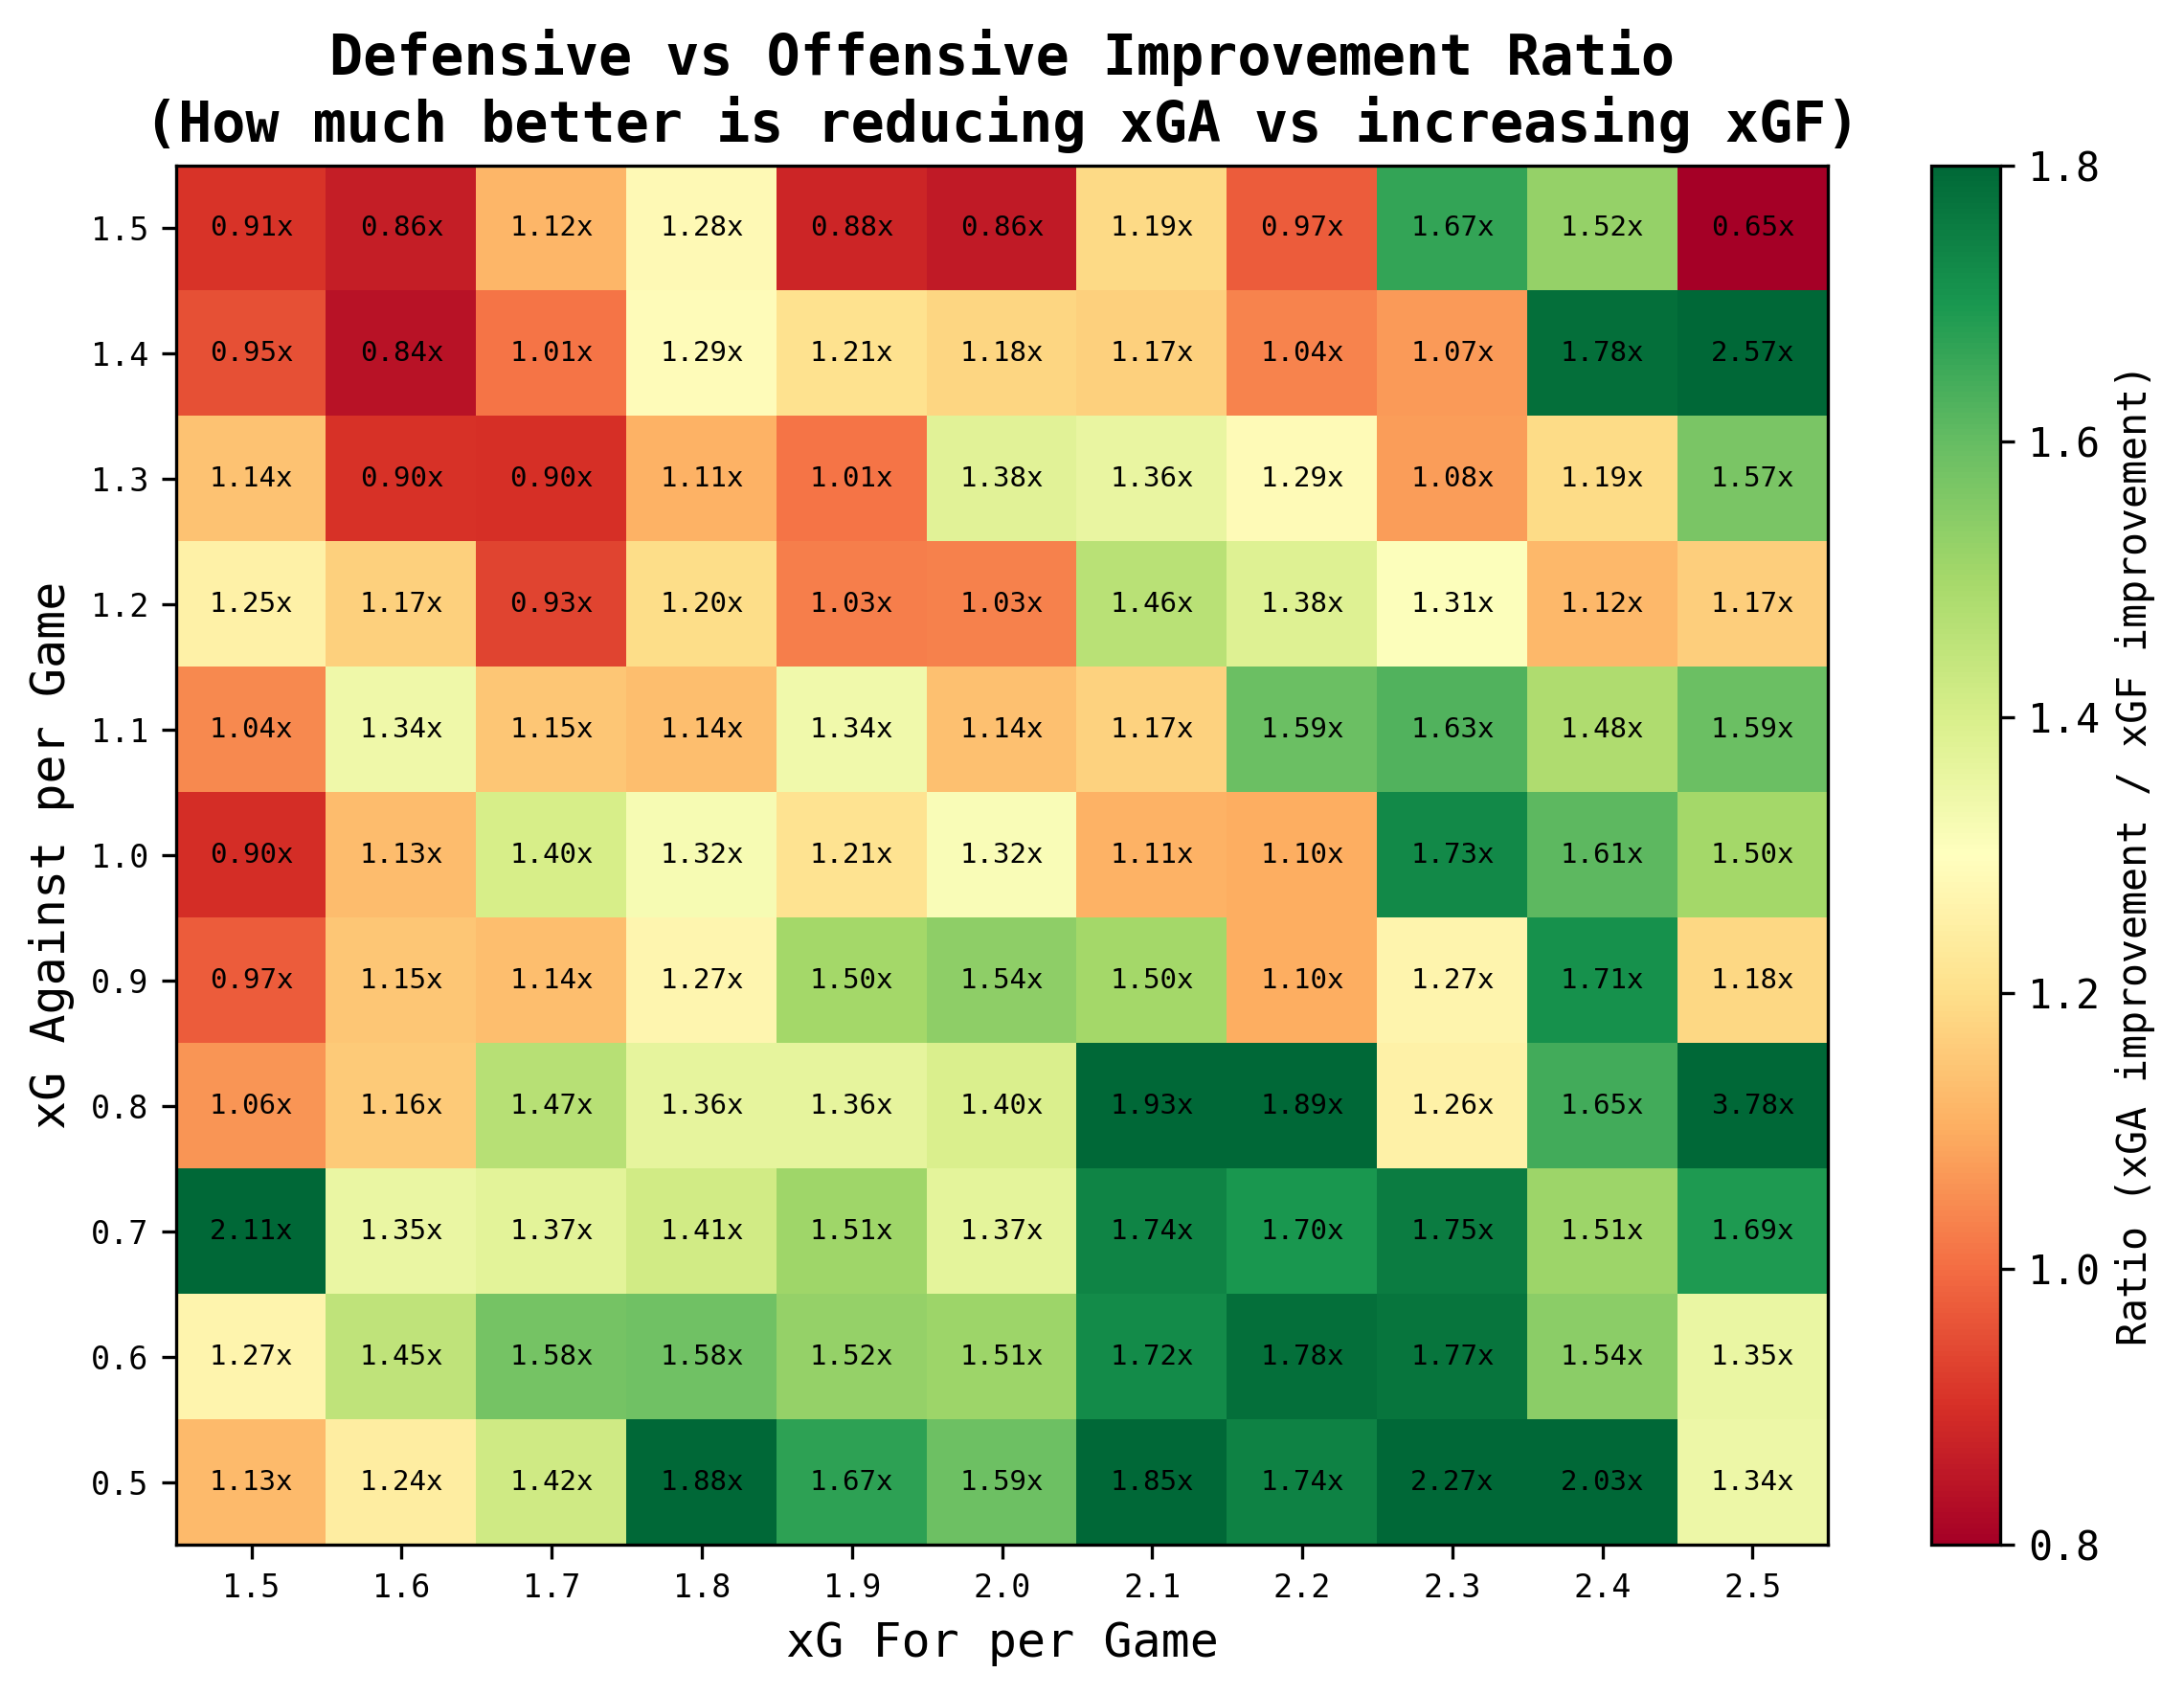

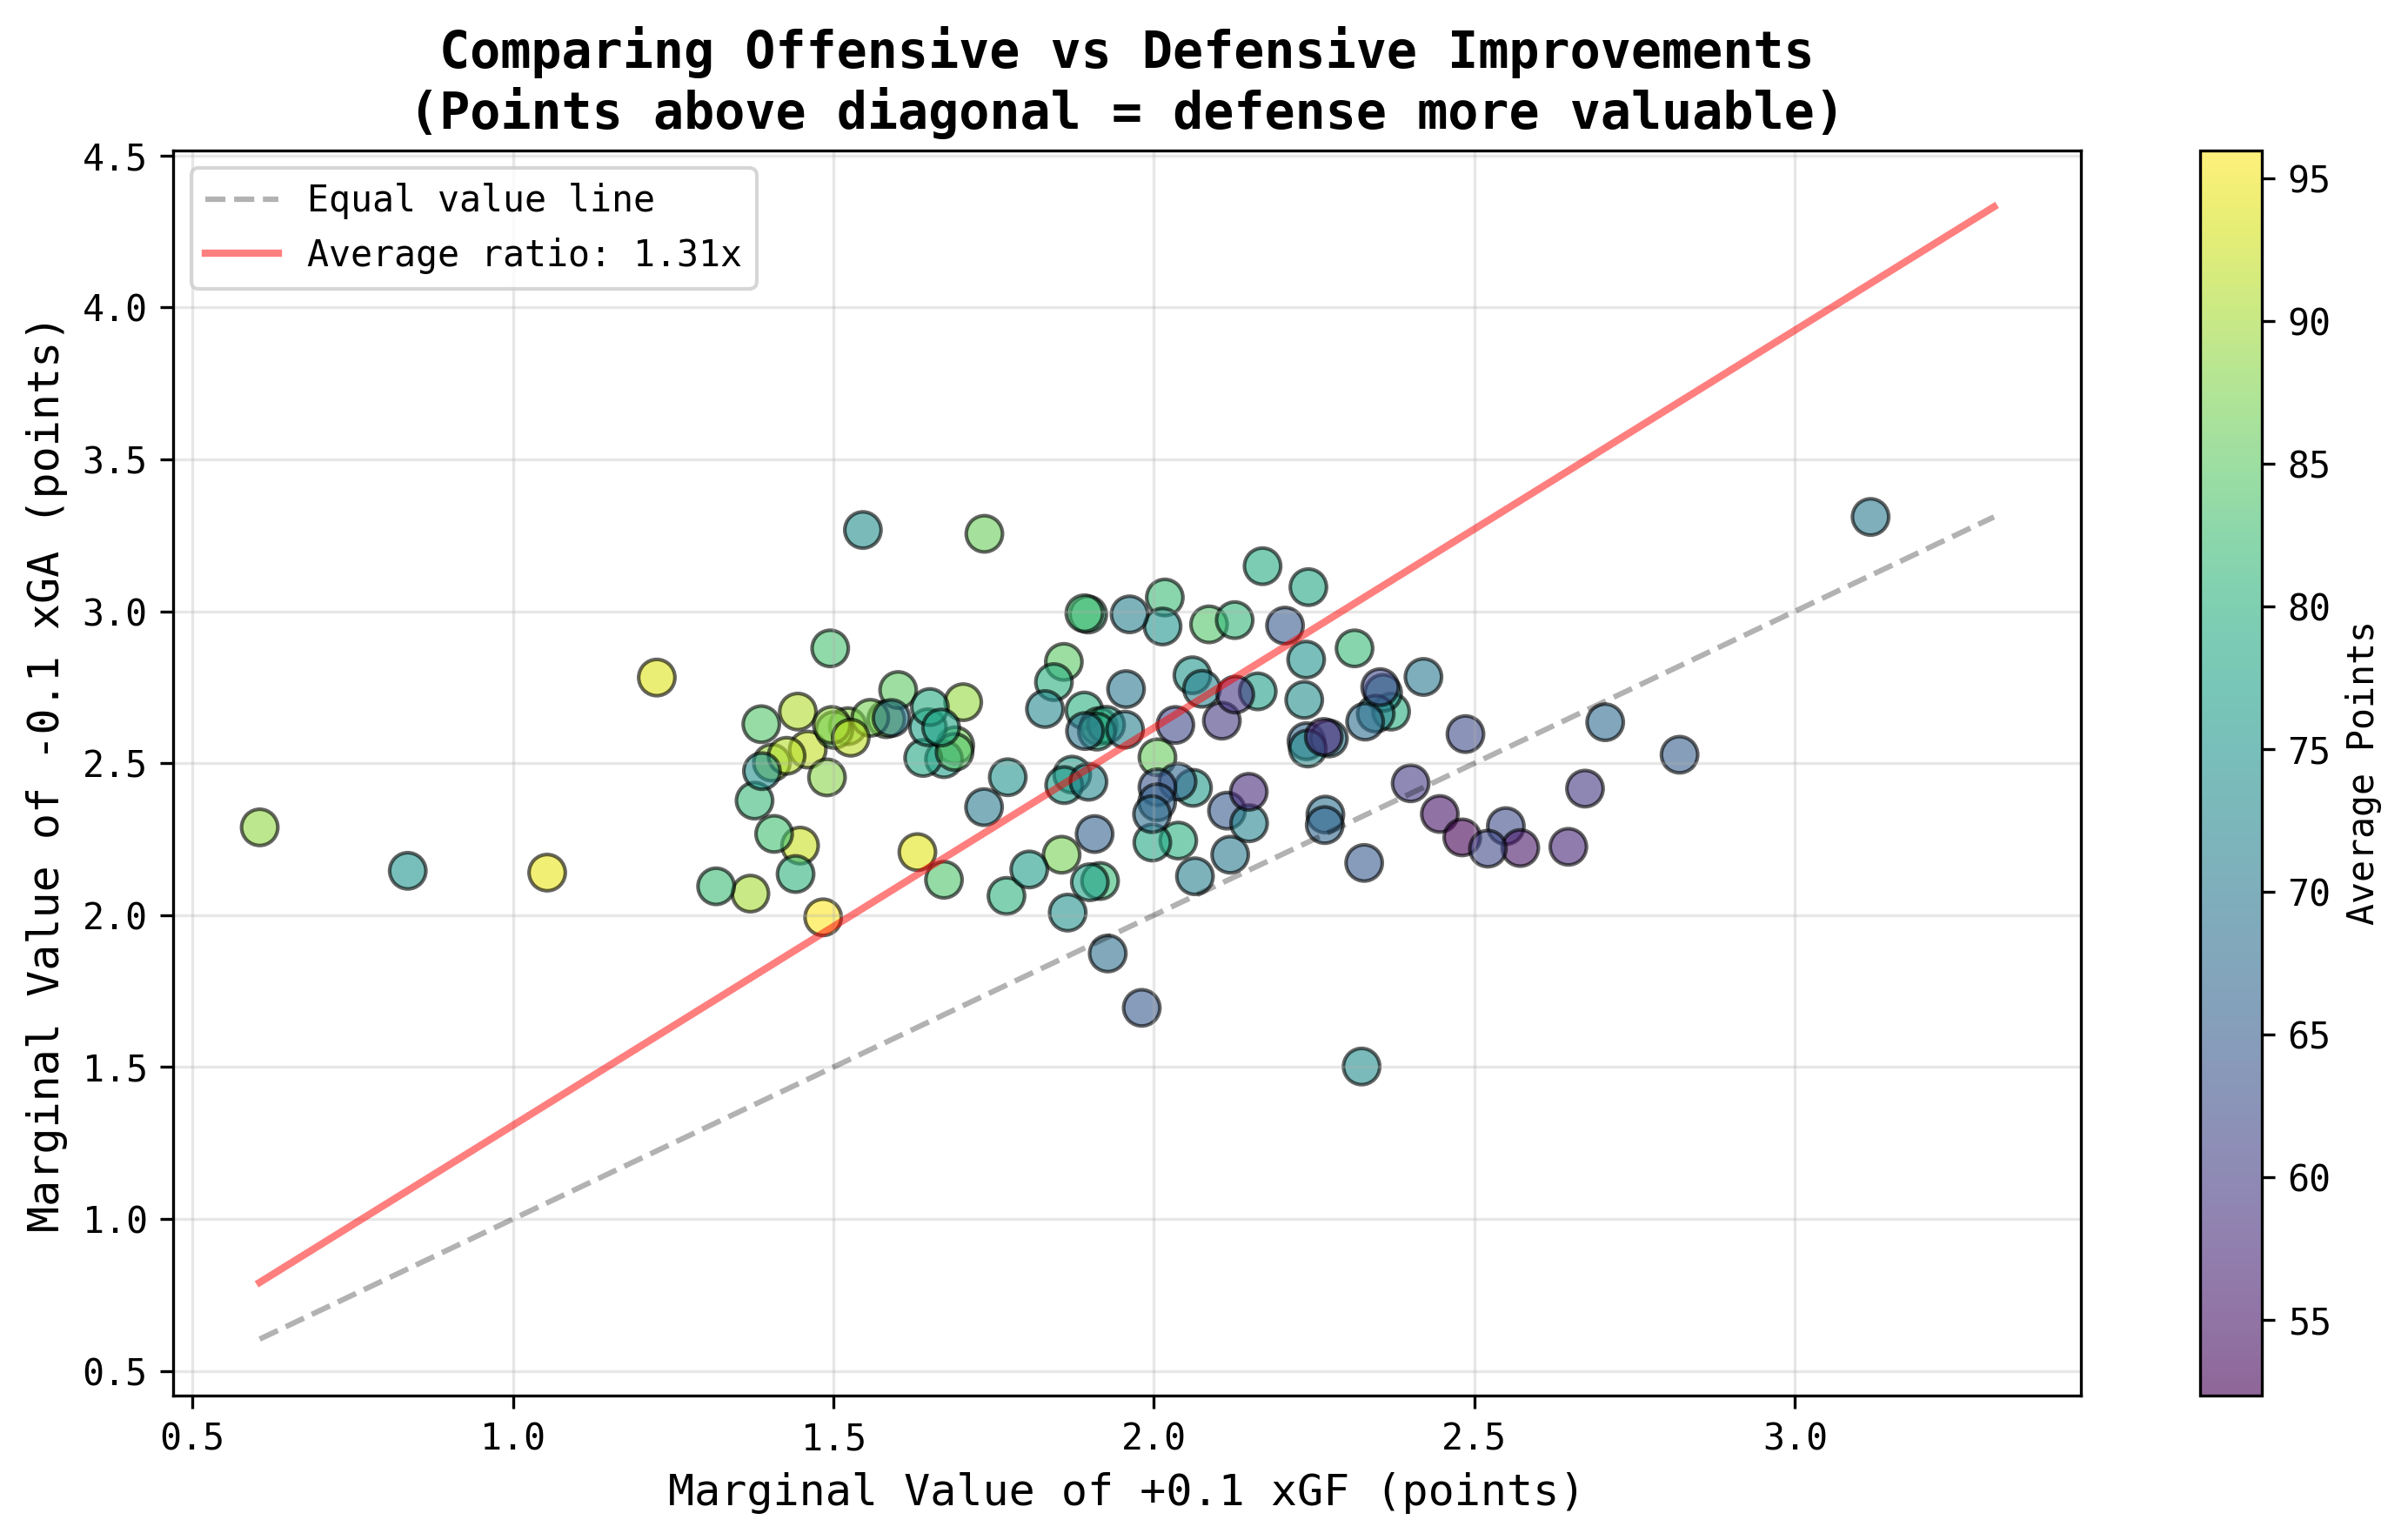


MARGINAL IMPROVEMENT COMPARISON
Average value of +0.1 xGF: 1.92 points
Average value of -0.1 xGA: 2.52 points

Ratio: 1.31x
Interpretation: Reducing xGA by 0.1 is worth 1.31x more than increasing xGF by 0.1

Range of ratios across all scenarios: 0.65x to 3.78x


In [11]:
def plot_marginal_comparison(results):
    """Create visualizations comparing xGF vs xGA marginal improvements."""
    xgf_vals = results['xgf_vals']
    xga_vals = results['xga_vals']
    
    # Calculate step sizes
    xgf_step = xgf_vals[1] - xgf_vals[0]
    xga_step = xga_vals[1] - xga_vals[0]
    
    # Recalculate marginal effects
    marginal_xgf = np.gradient(results['avg_points'], axis=1) * (0.1 / xgf_step)
    marginal_xga = -np.gradient(results['avg_points'], axis=0) * (0.1 / xga_step)
    
    # Option 1: Ratio heatmap showing how much better xGA improvement is
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    ratio = marginal_xga / marginal_xgf
    
    extent = [xgf_vals[0] - xgf_step/2, xgf_vals[-1] + xgf_step/2,
              xga_vals[0] - xga_step/2, xga_vals[-1] + xga_step/2]
    
    im1 = ax1.imshow(ratio, aspect='auto', origin='lower',
                     extent=extent, cmap='RdYlGn', vmin=0.8, vmax=1.8)
    ax1.set_xlabel('xG For per Game', fontsize=12)
    ax1.set_ylabel('xG Against per Game', fontsize=12)
    ax1.set_title('Defensive vs Offensive Improvement Ratio\n(How much better is reducing xGA vs increasing xGF)', 
                  fontsize=14, fontweight='bold')
    
    ax1.set_xticks(xgf_vals)
    ax1.set_yticks(xga_vals)
    ax1.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax1.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    cbar = plt.colorbar(im1, ax=ax1, label='Ratio (xGA improvement / xGF improvement)')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax1.text(xgf_vals[j], xga_vals[i], f'{ratio[i, j]:.2f}x',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Option 2: Scatter plot showing relationship
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    # Flatten arrays for scatter plot
    marginal_xgf_flat = marginal_xgf.flatten()
    marginal_xga_flat = marginal_xga.flatten()
    
    scatter = ax2.scatter(marginal_xgf_flat, marginal_xga_flat, 
                         c=results['avg_points'].flatten(), 
                         cmap='viridis', s=100, alpha=0.6, edgecolors='black')
    
    # Add diagonal line showing equal value
    min_val = min(marginal_xgf_flat.min(), marginal_xga_flat.min())
    max_val = max(marginal_xgf_flat.max(), marginal_xga_flat.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Equal value line')
    
    # Add average ratio line
    avg_ratio = marginal_xga.mean() / marginal_xgf.mean()
    x_line = np.linspace(min_val, max_val, 100)
    ax2.plot(x_line, x_line * avg_ratio, 'r-', alpha=0.5, linewidth=2,
            label=f'Average ratio: {avg_ratio:.2f}x')
    
    ax2.set_xlabel('Marginal Value of +0.1 xGF (points)', fontsize=12)
    ax2.set_ylabel('Marginal Value of -0.1 xGA (points)', fontsize=12)
    ax2.set_title('Comparing Offensive vs Defensive Improvements\n(Points above diagonal = defense more valuable)', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(alpha=0.3)
    
    plt.colorbar(scatter, ax=ax2, label='Average Points')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*60)
    print("MARGINAL IMPROVEMENT COMPARISON")
    print("="*60)
    print(f"Average value of +0.1 xGF: {marginal_xgf.mean():.2f} points")
    print(f"Average value of -0.1 xGA: {marginal_xga.mean():.2f} points")
    print(f"\nRatio: {avg_ratio:.2f}x")
    print(f"Interpretation: Reducing xGA by 0.1 is worth {avg_ratio:.2f}x more than increasing xGF by 0.1")
    print(f"\nRange of ratios across all scenarios: {ratio.min():.2f}x to {ratio.max():.2f}x")

plot_marginal_comparison(results)

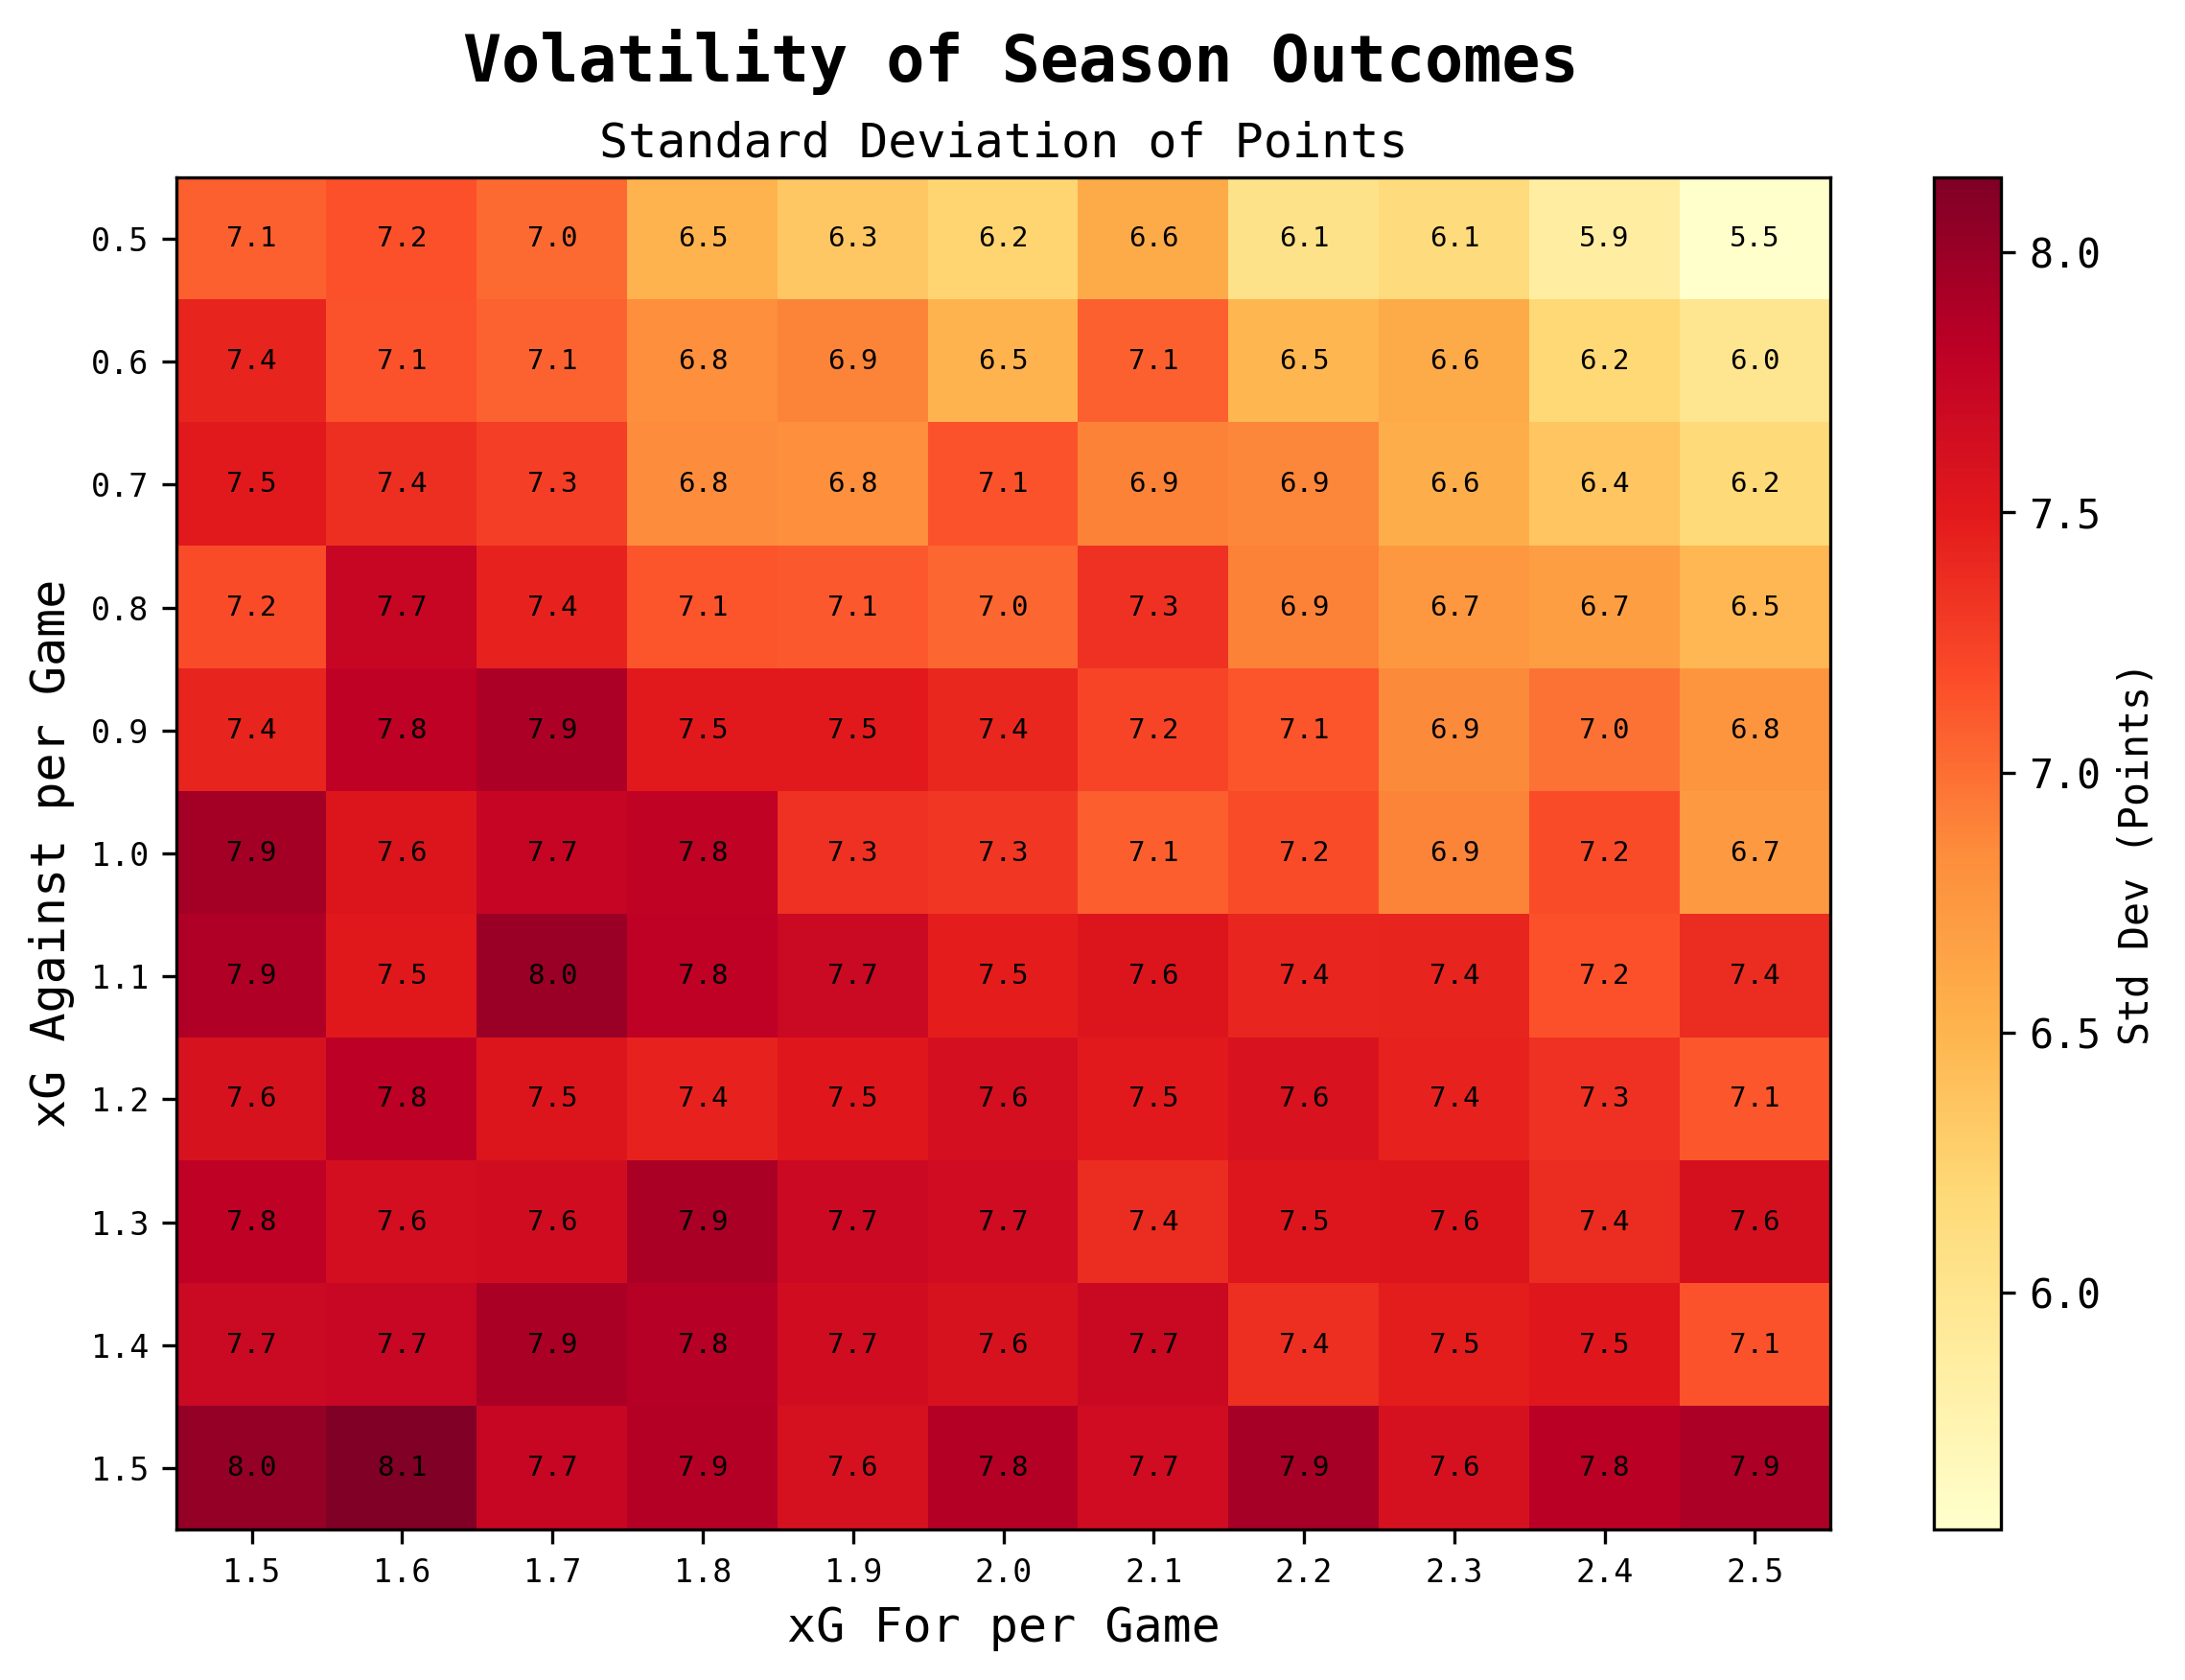

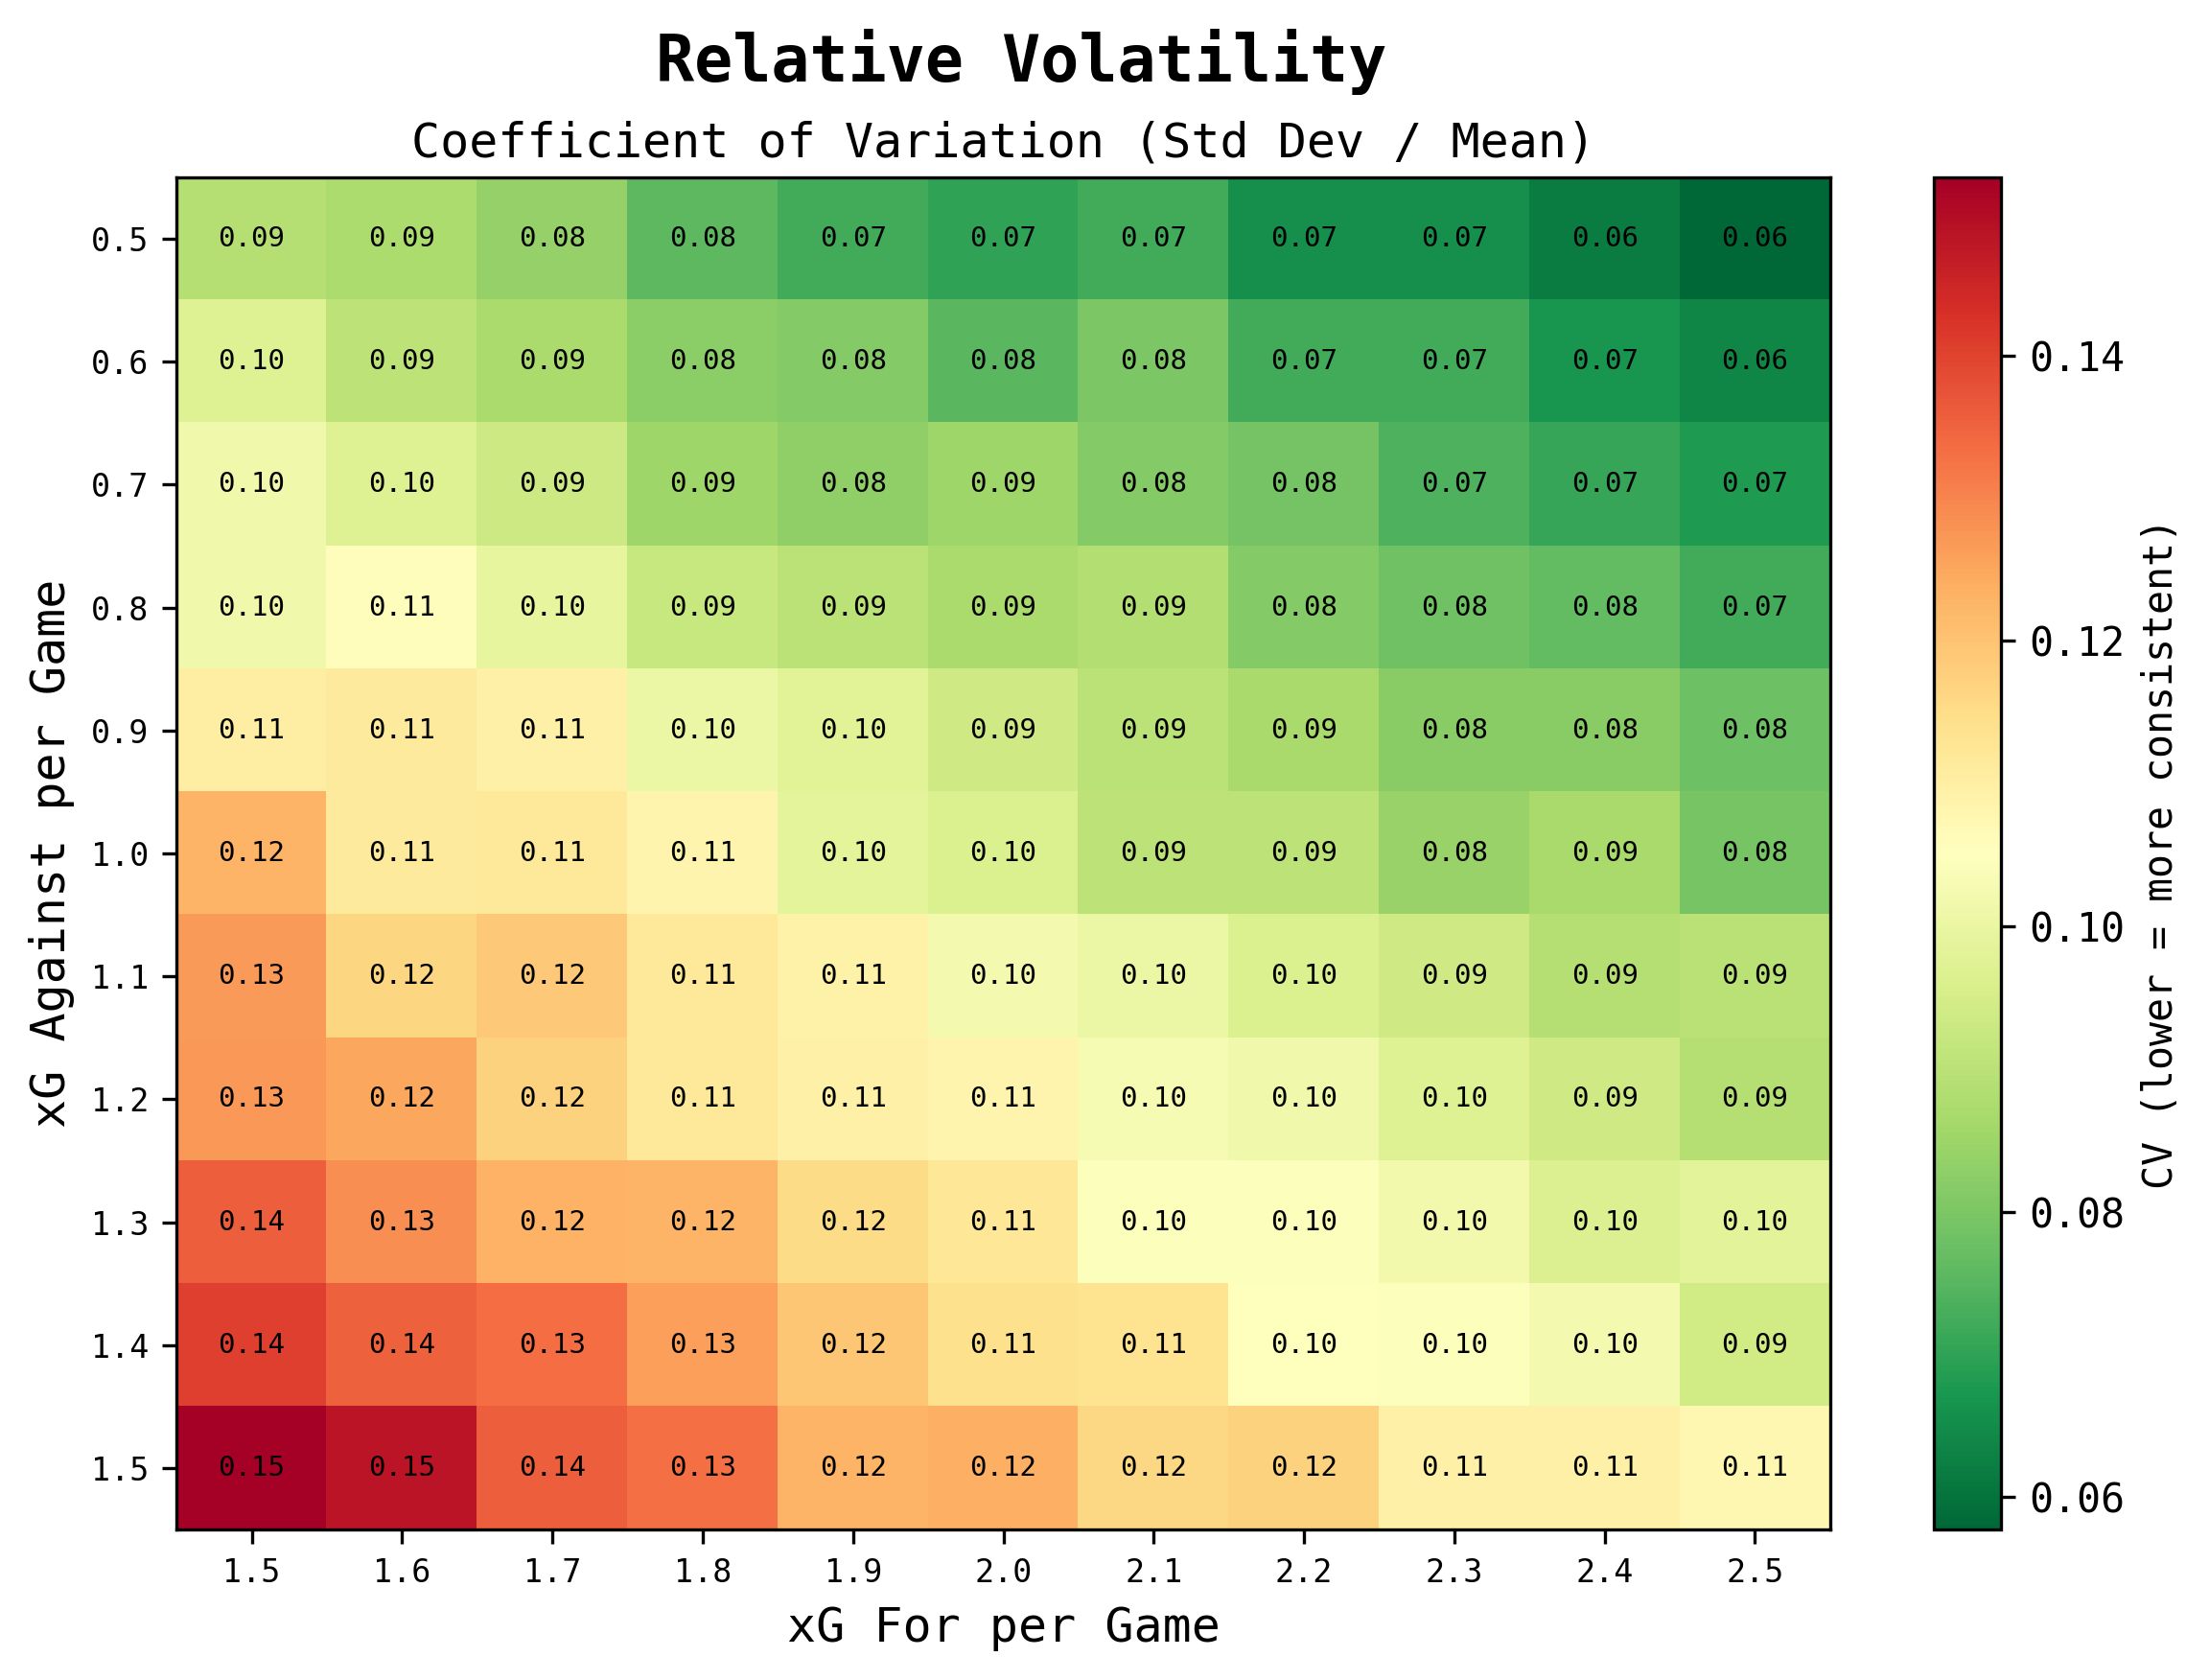

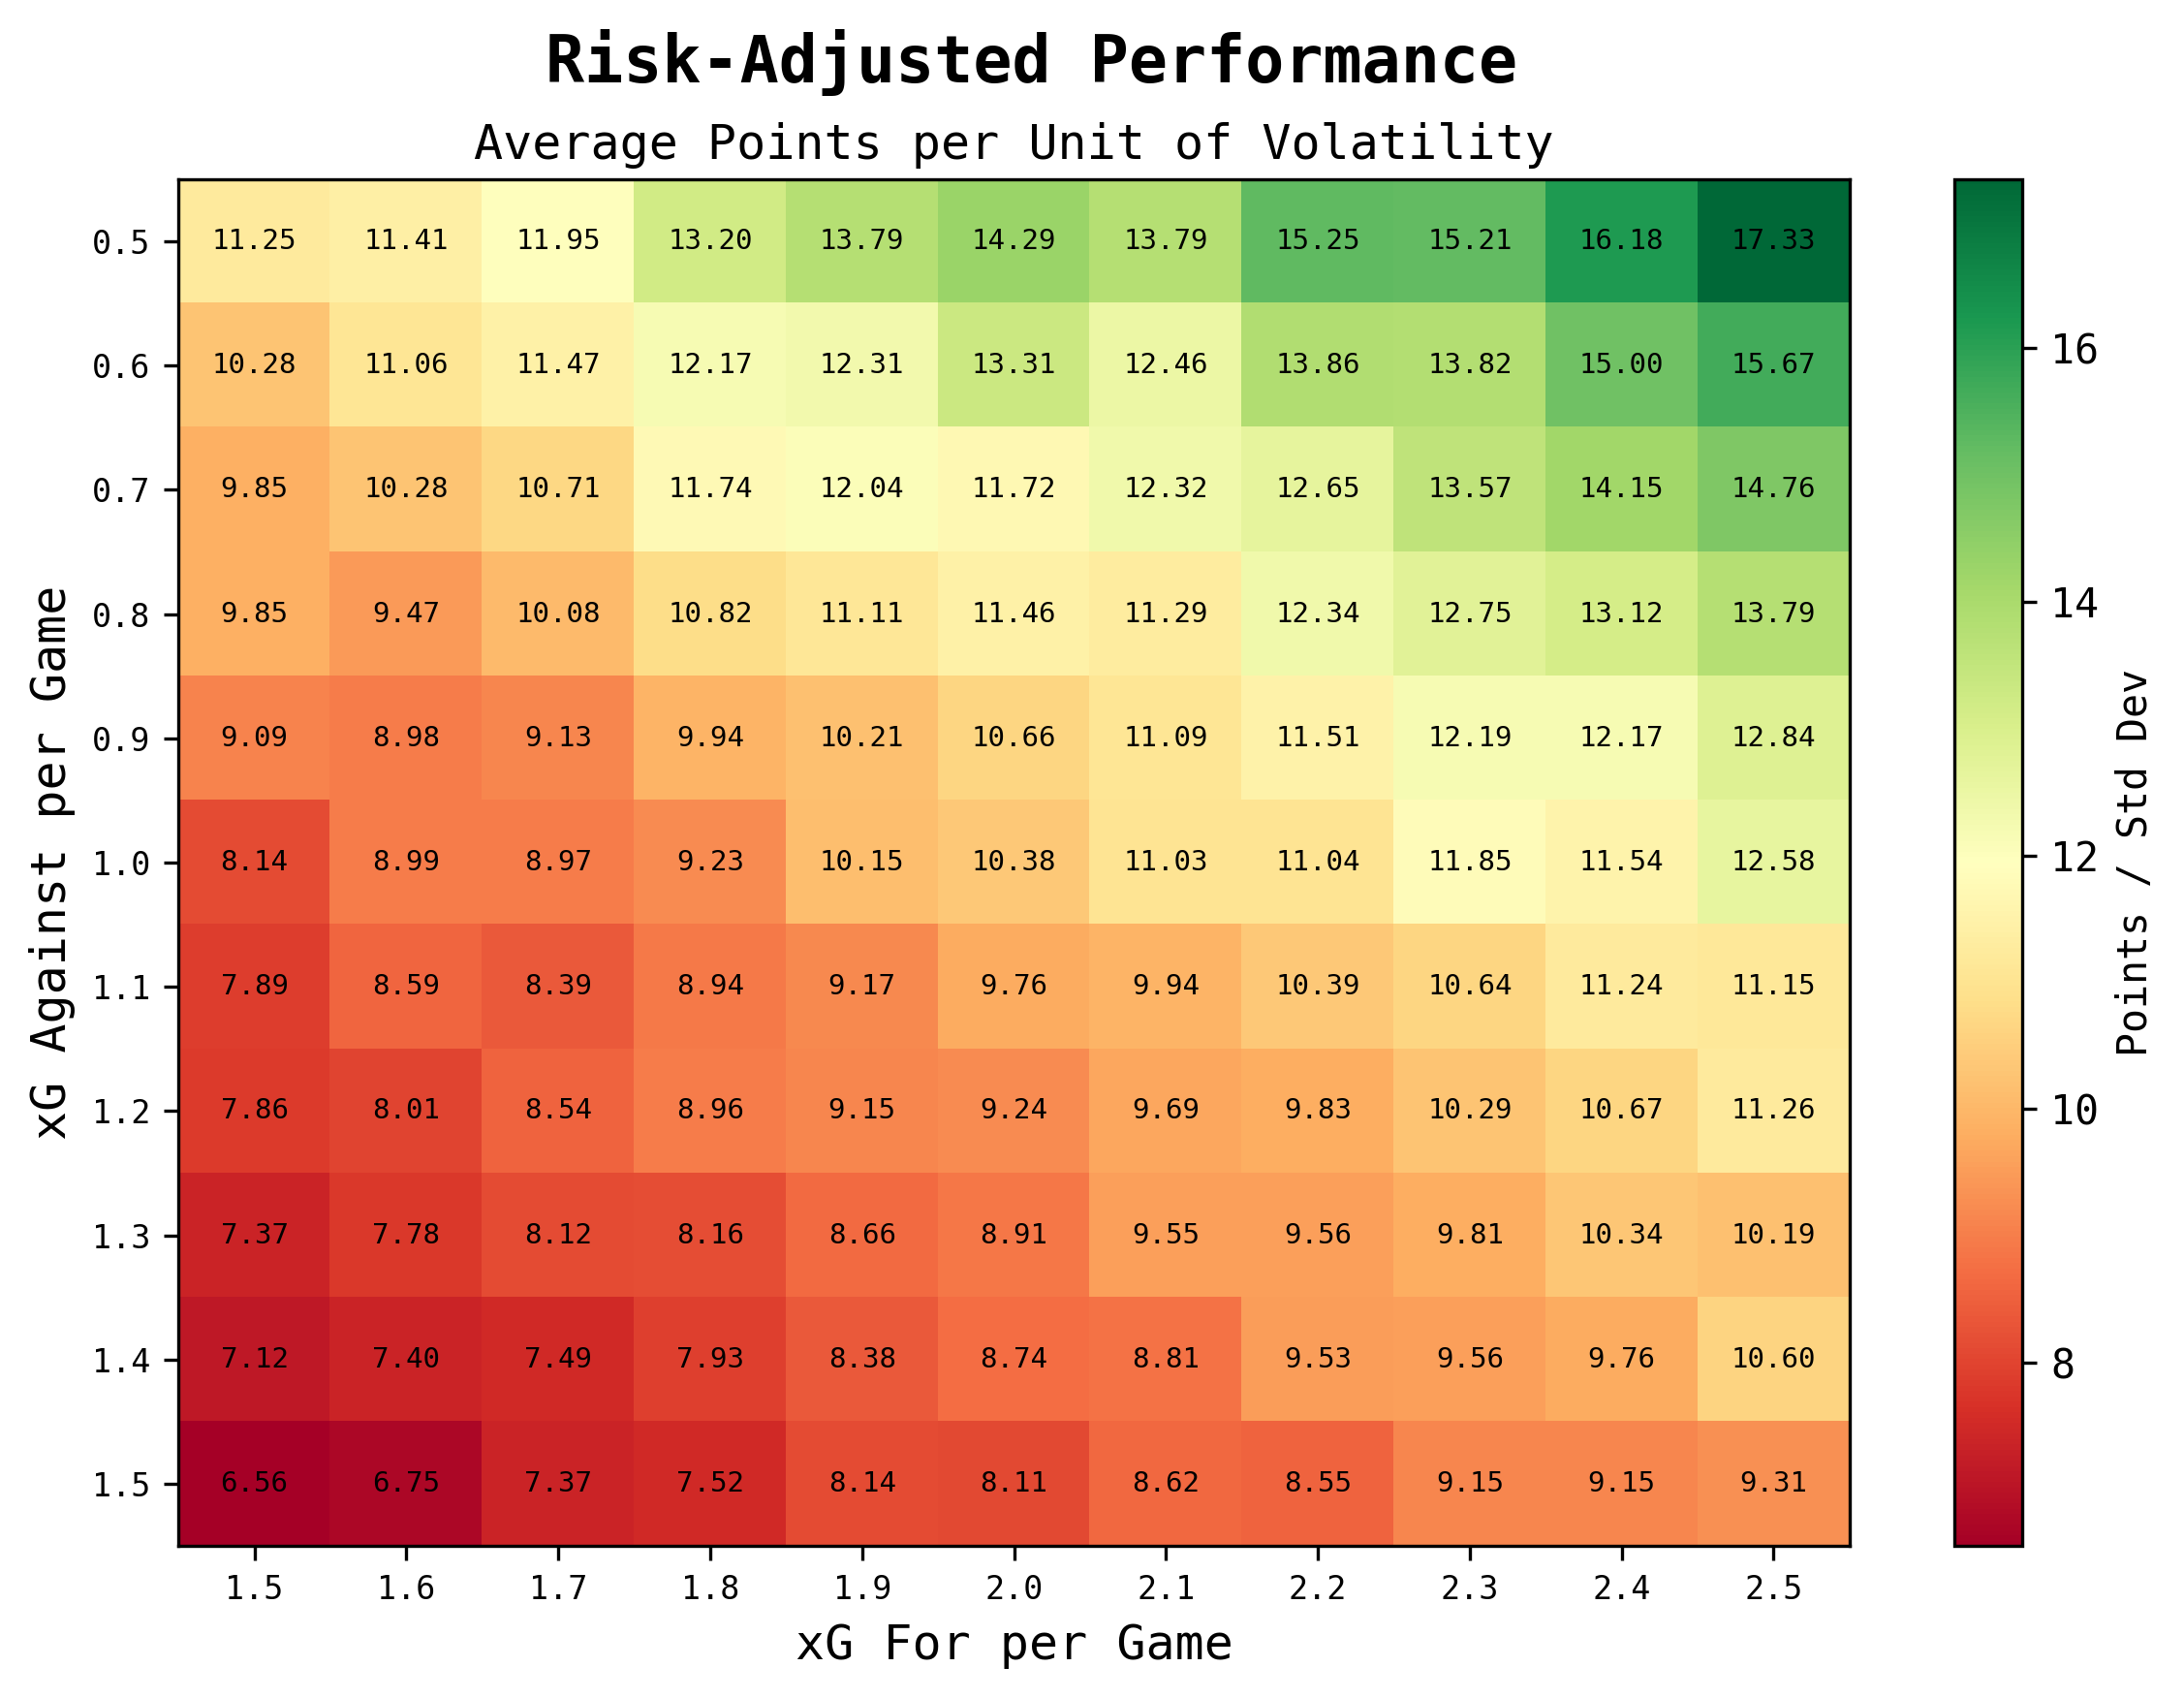


VARIANCE & RISK ANALYSIS

Comparing teams with similar xGD but different profiles:

  xGD ≈ 1.0:
    1.5xGF / 0.5xGA: 79.6 ± 7.1 pts (CV: 0.09)
    1.6xGF / 0.5xGA: 81.7 ± 7.2 pts (CV: 0.09)
    1.5xGF / 0.6xGA: 76.4 ± 7.4 pts (CV: 0.10)
    1.6xGF / 0.6xGA: 79.0 ± 7.1 pts (CV: 0.09)
    1.7xGF / 0.6xGA: 81.0 ± 7.1 pts (CV: 0.09)
    1.6xGF / 0.7xGA: 75.7 ± 7.4 pts (CV: 0.10)
    1.7xGF / 0.7xGA: 77.8 ± 7.3 pts (CV: 0.09)
    1.8xGF / 0.7xGA: 80.3 ± 6.8 pts (CV: 0.09)
    1.7xGF / 0.8xGA: 74.9 ± 7.4 pts (CV: 0.10)
    1.8xGF / 0.8xGA: 77.2 ± 7.1 pts (CV: 0.09)
    1.9xGF / 0.8xGA: 79.1 ± 7.1 pts (CV: 0.09)
    1.8xGF / 0.9xGA: 74.5 ± 7.5 pts (CV: 0.10)
    1.9xGF / 0.9xGA: 76.6 ± 7.5 pts (CV: 0.10)
    2.0xGF / 0.9xGA: 79.0 ± 7.4 pts (CV: 0.09)
    1.9xGF / 1.0xGA: 74.6 ± 7.3 pts (CV: 0.10)
    2.0xGF / 1.0xGA: 75.9 ± 7.3 pts (CV: 0.10)
    2.1xGF / 1.0xGA: 78.2 ± 7.1 pts (CV: 0.09)
    2.0xGF / 1.1xGA: 72.9 ± 7.5 pts (CV: 0.10)
    2.1xGF / 1.1xGA: 75.1 ± 7.6 pts (CV: 0.10)
    2.2xG

In [51]:
def plot_variance_analysis(avg_points, std_points, xgf_vals, xga_vals):
    """Analyze variance and risk across different xG/xGA profiles."""
    
    # Calculate step sizes for extent
    xgf_step = xgf_vals[1] - xgf_vals[0]
    xga_step = xga_vals[1] - xga_vals[0]
    extent = [xgf_vals[0] - xgf_step/2, xgf_vals[-1] + xgf_step/2,
              xga_vals[0] - xga_step/2, xga_vals[-1] + xga_step/2]
    
    # Calculate coefficient of variation (CV = std/mean)
    # This normalizes volatility relative to expected performance
    cv_points = std_points / avg_points
    
    # Calculate "risk-adjusted returns" (avg points per unit of volatility)
    risk_adjusted = avg_points / std_points
    
    # Chart 1: Standard Deviation of Points
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    im1 = ax1.imshow(std_points, aspect='auto', origin='lower',
                     extent=extent, cmap='YlOrRd')
    ax1.set_xlabel('xG For per Game', fontsize=12)
    ax1.set_ylabel('xG Against per Game', fontsize=12)
    fig1.suptitle('Volatility of Season Outcomes', fontsize=16, fontweight='bold', x=0.45, y=0.965)
    ax1.set_title('Standard Deviation of Points', fontsize=12, pad=5)
    
    ax1.invert_yaxis()
    ax1.set_xticks(xgf_vals)
    ax1.set_yticks(xga_vals)
    ax1.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax1.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im1, ax=ax1, label='Std Dev (Points)')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax1.text(xgf_vals[j], xga_vals[i], f'{std_points[i, j]:.1f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Chart 2: Coefficient of Variation
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    im2 = ax2.imshow(cv_points, aspect='auto', origin='lower',
                     extent=extent, cmap='RdYlGn_r')
    ax2.set_xlabel('xG For per Game', fontsize=12)
    ax2.set_ylabel('xG Against per Game', fontsize=12)
    fig2.suptitle('Relative Volatility', fontsize=16, fontweight='bold', x=0.45, y=0.965)
    ax2.set_title('Coefficient of Variation (Std Dev / Mean)', fontsize=12, pad=5)
    
    ax2.invert_yaxis()
    ax2.set_xticks(xgf_vals)
    ax2.set_yticks(xga_vals)
    ax2.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax2.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im2, ax=ax2, label='CV (lower = more consistent)')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax2.text(xgf_vals[j], xga_vals[i], f'{cv_points[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Chart 3: Risk-Adjusted Performance
    fig3, ax3 = plt.subplots(figsize=(8, 6))
    im3 = ax3.imshow(risk_adjusted, aspect='auto', origin='lower',
                     extent=extent, cmap='RdYlGn')
    ax3.set_xlabel('xG For per Game', fontsize=12)
    ax3.set_ylabel('xG Against per Game', fontsize=12)
    fig3.suptitle('Risk-Adjusted Performance', fontsize=16, fontweight='bold', x=0.45, y=0.965)
    ax3.set_title('Average Points per Unit of Volatility', fontsize=12, pad=5)
    
    ax3.invert_yaxis()
    ax3.set_xticks(xgf_vals)
    ax3.set_yticks(xga_vals)
    ax3.set_xticklabels([f'{x:.1f}' for x in xgf_vals], fontsize=8)
    ax3.set_yticklabels([f'{y:.1f}' for y in xga_vals], fontsize=8)
    
    plt.colorbar(im3, ax=ax3, label='Points / Std Dev')
    
    for i in range(len(xga_vals)):
        for j in range(len(xgf_vals)):
            ax3.text(xgf_vals[j], xga_vals[i], f'{risk_adjusted[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics comparing profiles with similar xGD
    print("\n" + "="*60)
    print("VARIANCE & RISK ANALYSIS")
    print("="*60)
    
    # Compare teams with similar xGD but different profiles
    print("\nComparing teams with similar xGD but different profiles:")
    
    # Find pairs with similar xGD
    xgd_grid = xgf_vals[:, np.newaxis] - xga_vals[np.newaxis, :]
    
    for target_xgd in [1.0, 1.5, 2.0]:
        print(f"\n  xGD ≈ {target_xgd}:")
        
        # Find profiles close to this xGD
        close_profiles = np.abs(xgd_grid - target_xgd) < 0.15
        
        if close_profiles.any():
            indices = np.where(close_profiles)
            
            for idx in range(len(indices[0])):
                i, j = indices[0][idx], indices[1][idx]
                xgf, xga = xgf_vals[j], xga_vals[i]
                print(f"    {xgf:.1f}xGF / {xga:.1f}xGA: "
                      f"{avg_points[i,j]:.1f} ± {std_points[i,j]:.1f} pts "
                      f"(CV: {cv_points[i,j]:.2f})")
    
    # Overall insights
    print(f"\nOverall patterns:")
    print(f"  Average volatility: {std_points.mean():.2f} points")
    print(f"  Lowest volatility: {std_points.min():.2f} points at "
          f"xGF={xgf_vals[np.unravel_index(std_points.argmin(), std_points.shape)[1]]:.1f}, "
          f"xGA={xga_vals[np.unravel_index(std_points.argmin(), std_points.shape)[0]]:.1f}")
    print(f"  Highest volatility: {std_points.max():.2f} points at "
          f"xGF={xgf_vals[np.unravel_index(std_points.argmax(), std_points.shape)[1]]:.1f}, "
          f"xGA={xga_vals[np.unravel_index(std_points.argmax(), std_points.shape)[0]]:.1f}")

# Call the variance analysis with your results dictionary
plot_variance_analysis(
    results['avg_points'], 
    results['std_points'], 
    results['xgf_vals'], 
    results['xga_vals']
)

In [46]:
# Check if these variables exist in your namespace
print("avg_points exists:", 'avg_points' in dir())
print("xgf_vals exists:", 'xgf_vals' in dir())
print("std_points exists:", 'std_points' in dir())

# Or check what variables you have
import numpy as np
variables = [name for name in dir() if not name.startswith('_') and isinstance(eval(name), np.ndarray)]
print("\nNumpy arrays in namespace:", variables)

avg_points exists: False
xgf_vals exists: False
std_points exists: False

Numpy arrays in namespace: ['att_str', 'att_str_initial', 'def_str', 'def_str_initial', 'other_att', 'other_def']


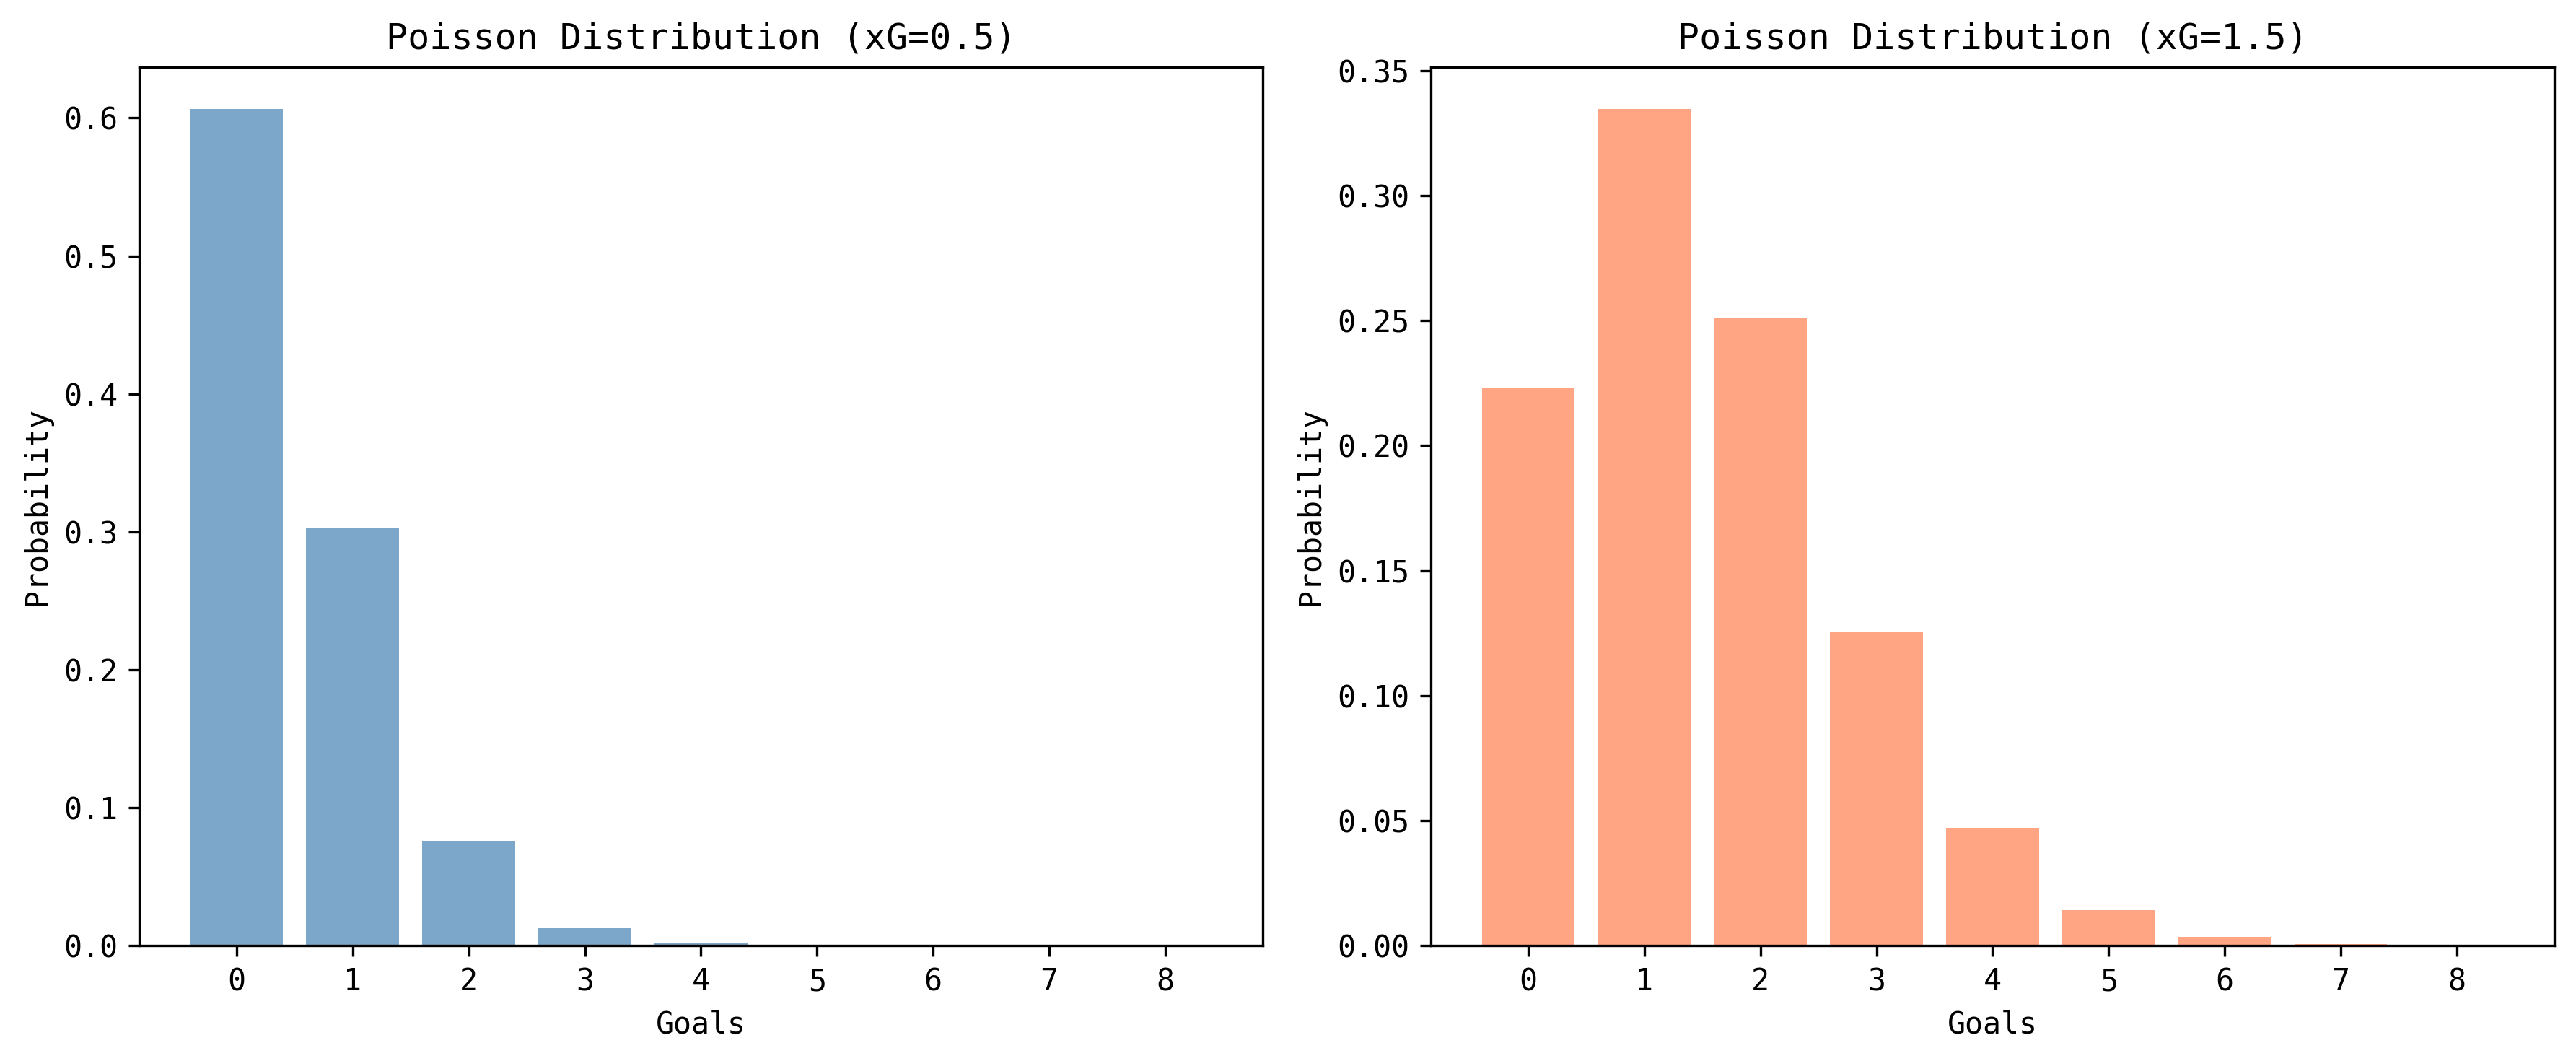

In [55]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

lambda1 = 0.5
lambda2 = 1.5
max_goals = 8

goals = np.arange(0, max_goals + 1)
prob1 = poisson.pmf(goals, lambda1)
prob2 = poisson.pmf(goals, lambda2)

# Create side-by-side bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(goals, prob1, color='steelblue', alpha=0.7)
ax1.set_title(f'Poisson Distribution (xG={lambda1})')
ax1.set_xlabel('Goals')
ax1.set_ylabel('Probability')
ax1.set_xticks(goals)

ax2.bar(goals, prob2, color='coral', alpha=0.7)
ax2.set_title(f'Poisson Distribution (xG={lambda2})')
ax2.set_xlabel('Goals')
ax2.set_ylabel('Probability')
ax2.set_xticks(goals)

plt.tight_layout()
plt.show()

Running goal share analysis...
Testing: 70% share of total goals from 2.0 to 4.0 (stepping at 0.25)

Testing 70% goal share across different total goal volumes
Total Goals  xGF      xGA      Avg Points   Std Dev
2.00         1.40     0.60     74.29        7.17
2.25         1.57     0.68     76.12        7.22
2.50         1.75     0.75     77.28        7.22
2.75         1.92     0.83     79.25        7.14
3.00         2.10     0.90     80.73        7.43
3.25         2.27     0.98     81.18        7.03
3.50         2.45     1.05     82.51        7.04
3.75         2.62     1.13     83.83        6.80
4.00         2.80     1.20     84.95        7.12

ANALYSIS COMPLETE!

Summary:
Goal share tested: 70%
Total goals range: 2.00 - 4.00

Highest average points: 84.95 at 4.00 total goals
Lowest variance: 6.80 at 3.75 total goals

Results saved to 'goal_share_analysis_70pct.pkl'
Visualization saved to 'goal_share_analysis_70pct.png'


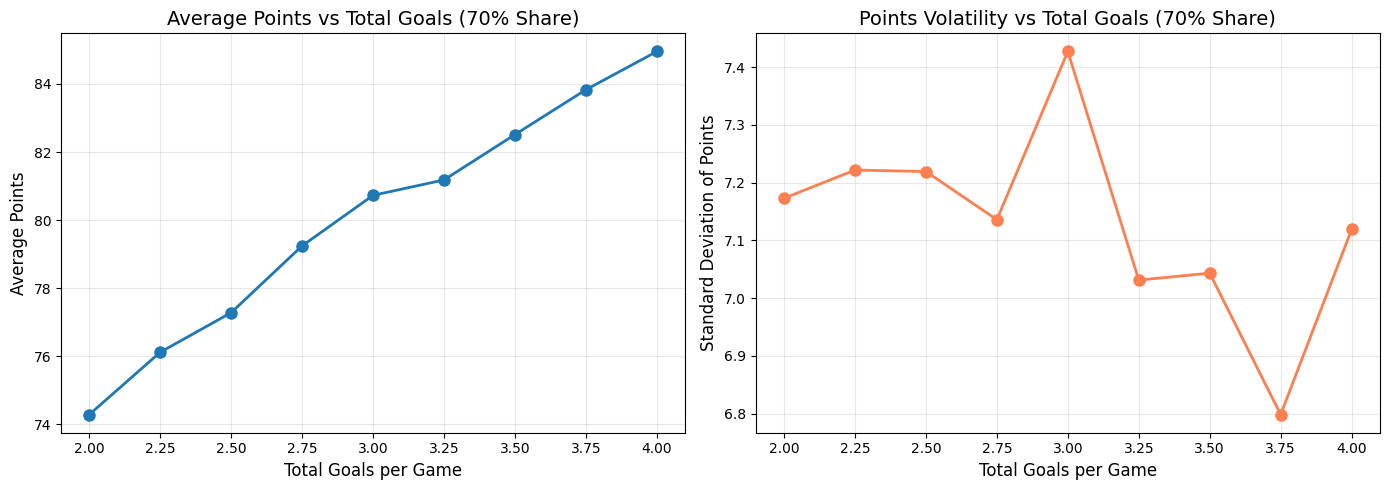

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_required_strengths(target_xgf, target_xga, baseline, home_adv,
                                 other_teams_att, other_teams_def):
    """Calculate attack and defense strengths needed to achieve target xG."""
    other_teams_att = np.array(other_teams_att)
    other_teams_def = np.array(other_teams_def)
    
    avg_opp_att = np.mean(other_teams_att)
    avg_opp_def = np.mean(other_teams_def)
    
    required_att = np.log(2 * target_xgf / (np.exp(home_adv) + 1)) - baseline - avg_opp_def
    required_def = np.log(2 * target_xga / (1 + np.exp(home_adv))) - baseline - avg_opp_att
    
    return required_att, required_def

def run_goal_share_analysis(goal_share=0.70, total_goals_range=(2.0, 4.0), 
                            baseline=0.283, home_adv=0.253,
                            att_str_initial=None, def_str_initial=None, 
                            n_seasons=1000):
    """
    Run analysis for fixed goal share across different total goal volumes.
    
    Parameters:
    -----------
    goal_share : float
        Target share of total goals (e.g., 0.70 for 70%)
    total_goals_range : tuple
        (min, max) total goals per game to test
    n_seasons : int
        Number of seasons to simulate per configuration
    
    Returns:
    --------
    results : dict with keys 'total_goals', 'xgf_vals', 'xga_vals', 
                             'avg_points', 'std_points', 'all_points'
    """
    # Generate total goals values from 2.0 to 4.0, stepping at 0.25
    total_goals_vals = np.arange(total_goals_range[0], total_goals_range[1] + 0.25, 0.25)
    
    # Calculate corresponding xGF and xGA for each total
    xgf_vals = total_goals_vals * goal_share
    xga_vals = total_goals_vals * (1 - goal_share)
    
    n_configs = len(total_goals_vals)
    avg_points = np.zeros(n_configs)
    std_points = np.zeros(n_configs)
    all_points = np.zeros((n_configs, n_seasons))
    
    print(f"\nTesting {goal_share*100:.0f}% goal share across different total goal volumes")
    print("="*70)
    print(f"{'Total Goals':<12} {'xGF':<8} {'xGA':<8} {'Avg Points':<12} {'Std Dev'}")
    print("="*70)
    
    for i, total_goals in enumerate(total_goals_vals):
        xgf = xgf_vals[i]
        xga = xga_vals[i]
        
        print(f"{total_goals:<12.2f} {xgf:<8.2f} {xga:<8.2f}", end=" ")
        
        # Calculate required strengths with iteration
        att_str = att_str_initial.copy()
        def_str = def_str_initial.copy()
        
        other_att = att_str[1:]
        other_def = def_str[1:]
        
        att_strength, def_strength = calculate_required_strengths(
            target_xgf=xgf,
            target_xga=xga,
            baseline=baseline,
            home_adv=home_adv,
            other_teams_att=other_att,
            other_teams_def=other_def
        )
        
        # Iterate to account for adjustments
        for _ in range(10):
            att_str[0] = att_strength
            def_str[0] = def_strength
            
            required_att_sum = -att_str[0]
            required_def_sum = -def_str[0]
            
            current_att_sum = att_str[1:].sum()
            current_def_sum = def_str[1:].sum()
            
            att_adjustment = (required_att_sum - current_att_sum) / 19
            def_adjustment = (required_def_sum - current_def_sum) / 19
            
            att_str[1:] += att_adjustment
            def_str[1:] += def_adjustment
            
            att_strength_new, def_strength_new = calculate_required_strengths(
                target_xgf=xgf,
                target_xga=xga,
                baseline=baseline,
                home_adv=home_adv,
                other_teams_att=att_str[1:],
                other_teams_def=def_str[1:]
            )
            
            if abs(att_strength_new - att_strength) < 0.0001 and abs(def_strength_new - def_strength) < 0.0001:
                break
            
            att_strength = att_strength_new
            def_strength = def_strength_new
        
        att_str[0] = att_strength
        def_str[0] = def_strength
        
        # Create manual trace and run simulation
        manual_trace = create_manual_trace(
            att_str=att_str,
            def_str=def_str,
            baseline=baseline,
            home_adv=home_adv,
            n_samples=1000,
            pin_first_team=True
        )
        
        # Run multiple seasons and store ALL results
        points_list = []
        for season_idx in range(n_seasons):
            league_table, _ = simulate_full_season(manual_trace, team_mapping, is_manual=True)
            arsenal_points = league_table['Arsenal']['points']
            points_list.append(arsenal_points)
        
        # Store results
        all_points[i, :] = points_list
        avg_points[i] = np.mean(points_list)
        std_points[i] = np.std(points_list)
        
        print(f"{avg_points[i]:<12.2f} {std_points[i]:.2f}")
    
    print("="*70)
    
    return {
        'goal_share': goal_share,
        'total_goals': total_goals_vals,
        'xgf_vals': xgf_vals,
        'xga_vals': xga_vals,
        'avg_points': avg_points,
        'std_points': std_points,
        'all_points': all_points
    }

# Run the analysis
baseline = 0.283
home_adv = 0.253

att_str_initial = np.array([
    0.35, 0.162, -0.088, -0.035, -0.119, 0.26, -0.109, -0.175, -0.089, -0.181,
    -0.392, 0.424, 0.365, -0.079, 0.302, -0.188, -0.414, 0.197, -0.043, -0.151
])

def_str_initial = np.array([
    -0.712, 0.086, 0.015, -0.04, -0.018, 0.043, -0.099, -0.085, 0.021, 0.314,
    0.207, -0.217, -0.436, 0.104, 0.069, -0.04, 0.392, 0.103, 0.225, 0.068
])

print("Running goal share analysis...")
print("Testing: 70% share of total goals from 2.0 to 4.0 (stepping at 0.25)")

results = run_goal_share_analysis(
    goal_share=0.70,
    total_goals_range=(2.0, 4.0),
    baseline=baseline,
    home_adv=home_adv,
    att_str_initial=att_str_initial,
    def_str_initial=def_str_initial,
    n_seasons=1000
)

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

# Print summary
print("\nSummary:")
print(f"Goal share tested: {results['goal_share']*100:.0f}%")
print(f"Total goals range: {results['total_goals'][0]:.2f} - {results['total_goals'][-1]:.2f}")
print(f"\nHighest average points: {results['avg_points'].max():.2f} at {results['total_goals'][results['avg_points'].argmax()]:.2f} total goals")
print(f"Lowest variance: {results['std_points'].min():.2f} at {results['total_goals'][results['std_points'].argmin()]:.2f} total goals")

# Save results
import pickle
with open('goal_share_analysis_70pct.pkl', 'wb') as f:
    pickle.dump(results, f)
print("\nResults saved to 'goal_share_analysis_70pct.pkl'")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot average points
ax1.plot(results['total_goals'], results['avg_points'], 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Total Goals per Game', fontsize=12)
ax1.set_ylabel('Average Points', fontsize=12)
ax1.set_title(f'Average Points vs Total Goals ({results["goal_share"]*100:.0f}% Share)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot standard deviation
ax2.plot(results['total_goals'], results['std_points'], 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Total Goals per Game', fontsize=12)
ax2.set_ylabel('Standard Deviation of Points', fontsize=12)
ax2.set_title(f'Points Volatility vs Total Goals ({results["goal_share"]*100:.0f}% Share)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('goal_share_analysis_70pct.png', dpi=300, bbox_inches='tight')
print("Visualization saved to 'goal_share_analysis_70pct.png'")